## 1. Import Library

In [1]:
# Basic Library
import pandas as pd
import numpy as np
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder

# HP Tuning
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour, plot_optimization_history
from optuna.visualization import plot_parallel_coordinate, plot_slice, plot_param_importances

# Modeling
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss
from lightgbm import LGBMClassifier
import xgboost as xgb
import tensorflow as tf
import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## 2. Import Data

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
submission = pd.read_csv("data/sample_submission.csv")

## 3-1. LightGBM Modeling

In [3]:
pred_dict = {}
pred_test_dict = {}

### (1) HP Tuning

In [4]:
train_x = train.iloc[:, 1:-1]
train_y = train.iloc[:, -1:]
test_x = test.iloc[:, 1:]

In [5]:
def lgb_objective(trial: Trial) -> float:
    params_lgb = {
        "random_state": 42,
        "verbosity": -1,
        "n_estimators": 10000,
        "objective": "multiclass",
        "metric": "multi_logloss",
        'learning_rate': trial.suggest_uniform("learning_rate", 0.005, 0.05),
        "reg_alpha": trial.suggest_uniform("reg_alpha", 0.0, 1),
        "reg_lambda": trial.suggest_uniform("reg_lambda", 0.0, 1),
        "max_depth": trial.suggest_int("max_depth", 5, 8),
        "num_leaves": trial.suggest_int("num_leaves", 200, 1200),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0), # feature_fraction
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 10),
        "max_bin": trial.suggest_int("max_bin", 150, 400),
    }
    
    seed = 42
    kfold = StratifiedKFold(n_splits=5, random_state = seed, shuffle = True) # Cross-validation cv=5
    cv = np.zeros((train_x.shape[0], 4))

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):

        x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
        y_train, y_val = train_y.iloc[train_idx].values.ravel(), train_y.iloc[val_idx].values.ravel()

        lgbmodel = LGBMClassifier(**params_lgb)
                                                                                        # 진행상황 보고싶을때 -1을 100으로
        lgbmodel.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=30, verbose=-1) 
        cv[val_idx, :] = lgbmodel.predict_proba(x_val)
        
#     print('multi_logloss:', log_loss(train_y, cv))
    print('accuracy_score:', accuracy_score(train_y, np.argmax(cv, axis=1)))

    
    return accuracy_score(train_y, np.argmax(cv, axis=1))

In [6]:
sampler = TPESampler(seed=42)
lgb_study = optuna.create_study(study_name="lgb_parameter_opt", direction="maximize", sampler=sampler)
lgb_study.optimize(lgb_objective, n_trials=30)

lgb_best_hyperparams = lgb_study.best_trial.params
lgb_base_hyperparams = {'objective':'multiclass', 'n_estimators':10000,
                        'lambda_l1':lgb_best_hyperparams['reg_alpha'],
                        'lambda_l2':lgb_best_hyperparams['reg_lambda'],
                        'reg_alpha':None, 'reg_lambda':None
                       }
lgb_best_hyperparams.update(lgb_base_hyperparams)
print("The best hyperparameters are:\n", lgb_best_hyperparams)

[I 2022-03-16 00:09:38,042] A new study created in memory with name: lgb_parameter_opt
[I 2022-03-16 00:09:44,573] Trial 0 finished with value: 0.75203426124197 and parameters: {'learning_rate': 0.021854305348131316, 'reg_alpha': 0.9507143064099162, 'reg_lambda': 0.7319939418114051, 'max_depth': 7, 'num_leaves': 356, 'colsample_bytree': 0.5779972601681014, 'subsample': 0.05808361216819946, 'subsample_freq': 9, 'min_child_samples': 7, 'max_bin': 327}. Best is trial 0 with value: 0.75203426124197.


accuracy_score: 0.75203426124197


[I 2022-03-16 00:10:25,078] Trial 1 finished with value: 0.8329764453961456 and parameters: {'learning_rate': 0.0059263022433111105, 'reg_alpha': 0.9699098521619943, 'reg_lambda': 0.8324426408004217, 'max_depth': 5, 'num_leaves': 382, 'colsample_bytree': 0.5917022549267169, 'subsample': 0.3042422429595377, 'subsample_freq': 6, 'min_child_samples': 5, 'max_bin': 223}. Best is trial 1 with value: 0.8329764453961456.


accuracy_score: 0.8329764453961456


[I 2022-03-16 00:10:31,375] Trial 2 finished with value: 0.8119914346895075 and parameters: {'learning_rate': 0.03253338026250708, 'reg_alpha': 0.13949386065204183, 'reg_lambda': 0.29214464853521815, 'max_depth': 6, 'num_leaves': 656, 'colsample_bytree': 0.8925879806965068, 'subsample': 0.19967378215835974, 'subsample_freq': 6, 'min_child_samples': 6, 'max_bin': 161}. Best is trial 1 with value: 0.8329764453961456.


accuracy_score: 0.8119914346895075


[I 2022-03-16 00:10:46,332] Trial 3 finished with value: 0.8385438972162741 and parameters: {'learning_rate': 0.032339518335564726, 'reg_alpha': 0.17052412368729153, 'reg_lambda': 0.06505159298527952, 'max_depth': 8, 'num_leaves': 1166, 'colsample_bytree': 0.9041986740582306, 'subsample': 0.3046137691733707, 'subsample_freq': 1, 'min_child_samples': 7, 'max_bin': 260}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8385438972162741


[I 2022-03-16 00:11:17,165] Trial 4 finished with value: 0.8329764453961456 and parameters: {'learning_rate': 0.010491720568015048, 'reg_alpha': 0.4951769101112702, 'reg_lambda': 0.034388521115218396, 'max_depth': 8, 'num_leaves': 459, 'colsample_bytree': 0.831261142176991, 'subsample': 0.31171107608941095, 'subsample_freq': 6, 'min_child_samples': 6, 'max_bin': 196}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8329764453961456


[I 2022-03-16 00:11:24,907] Trial 5 finished with value: 0.7922912205567452 and parameters: {'learning_rate': 0.04863130824940514, 'reg_alpha': 0.7751328233611146, 'reg_lambda': 0.9394989415641891, 'max_depth': 8, 'num_leaves': 798, 'colsample_bytree': 0.9609371175115584, 'subsample': 0.0884925020519195, 'subsample_freq': 2, 'min_child_samples': 1, 'max_bin': 231}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.7922912205567452


[I 2022-03-16 00:11:41,194] Trial 6 finished with value: 0.7961456102783726 and parameters: {'learning_rate': 0.022490478036026693, 'reg_alpha': 0.2713490317738959, 'reg_lambda': 0.8287375091519293, 'max_depth': 6, 'num_leaves': 481, 'colsample_bytree': 0.7713480415791243, 'subsample': 0.14092422497476265, 'subsample_freq': 9, 'min_child_samples': 1, 'max_bin': 397}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.7961456102783726


[I 2022-03-16 00:11:54,936] Trial 7 finished with value: 0.8316916488222698 and parameters: {'learning_rate': 0.03975101461834959, 'reg_alpha': 0.1987156815341724, 'reg_lambda': 0.005522117123602399, 'max_depth': 8, 'num_leaves': 907, 'colsample_bytree': 0.8645035840204937, 'subsample': 0.7712703466859457, 'subsample_freq': 1, 'min_child_samples': 4, 'max_bin': 179}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8316916488222698


[I 2022-03-16 00:12:04,466] Trial 8 finished with value: 0.8269807280513919 and parameters: {'learning_rate': 0.04383965416440171, 'reg_alpha': 0.6232981268275579, 'reg_lambda': 0.3308980248526492, 'max_depth': 5, 'num_leaves': 511, 'colsample_bytree': 0.6625916610133735, 'subsample': 0.7296061783380641, 'subsample_freq': 7, 'min_child_samples': 9, 'max_bin': 268}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8269807280513919


[I 2022-03-16 00:12:45,485] Trial 9 finished with value: 0.8261241970021413 and parameters: {'learning_rate': 0.010381741067223577, 'reg_alpha': 0.713244787222995, 'reg_lambda': 0.7607850486168974, 'max_depth': 7, 'num_leaves': 971, 'colsample_bytree': 0.7468977981821954, 'subsample': 0.5227328293819941, 'subsample_freq': 5, 'min_child_samples': 1, 'max_bin': 177}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8261241970021413


[I 2022-03-16 00:13:03,634] Trial 10 finished with value: 0.828693790149893 and parameters: {'learning_rate': 0.031372948924236296, 'reg_alpha': 0.005997182955817026, 'reg_lambda': 0.5180371644945151, 'max_depth': 7, 'num_leaves': 1184, 'colsample_bytree': 0.953832397641259, 'subsample': 0.9597707459454201, 'subsample_freq': 3, 'min_child_samples': 10, 'max_bin': 311}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.828693790149893


[I 2022-03-16 00:13:20,367] Trial 11 finished with value: 0.8342612419700214 and parameters: {'learning_rate': 0.017634242940786696, 'reg_alpha': 0.40722506998049707, 'reg_lambda': 0.5109254638413363, 'max_depth': 5, 'num_leaves': 267, 'colsample_bytree': 0.5369184983570693, 'subsample': 0.4002255810220492, 'subsample_freq': 4, 'min_child_samples': 4, 'max_bin': 246}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8342612419700214


[I 2022-03-16 00:13:41,251] Trial 12 finished with value: 0.8355460385438972 and parameters: {'learning_rate': 0.01934521448400128, 'reg_alpha': 0.3743780629884814, 'reg_lambda': 0.46870521888784233, 'max_depth': 6, 'num_leaves': 227, 'colsample_bytree': 0.5167929424672362, 'subsample': 0.4812884929660226, 'subsample_freq': 4, 'min_child_samples': 3, 'max_bin': 271}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8355460385438972


[I 2022-03-16 00:13:55,246] Trial 13 finished with value: 0.8278372591006424 and parameters: {'learning_rate': 0.028180326743751198, 'reg_alpha': 0.32711556453252894, 'reg_lambda': 0.20197183757230486, 'max_depth': 6, 'num_leaves': 1165, 'colsample_bytree': 0.7000831872063953, 'subsample': 0.5460502071617208, 'subsample_freq': 1, 'min_child_samples': 8, 'max_bin': 307}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8278372591006424


[I 2022-03-16 00:14:18,440] Trial 14 finished with value: 0.8364025695931477 and parameters: {'learning_rate': 0.03654725381303922, 'reg_alpha': 0.03707527078075118, 'reg_lambda': 0.6206950820137881, 'max_depth': 7, 'num_leaves': 652, 'colsample_bytree': 0.5125324103836217, 'subsample': 0.6417871934804688, 'subsample_freq': 3, 'min_child_samples': 3, 'max_bin': 354}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8364025695931477


[I 2022-03-16 00:14:43,519] Trial 15 finished with value: 0.8334047109207708 and parameters: {'learning_rate': 0.03750920710982181, 'reg_alpha': 0.043852476646154326, 'reg_lambda': 0.6092599562105129, 'max_depth': 8, 'num_leaves': 591, 'colsample_bytree': 0.6454870852534472, 'subsample': 0.7420141585418611, 'subsample_freq': 2, 'min_child_samples': 3, 'max_bin': 372}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8334047109207708


[I 2022-03-16 00:14:57,782] Trial 16 finished with value: 0.828693790149893 and parameters: {'learning_rate': 0.037391105434223186, 'reg_alpha': 0.135920872655248, 'reg_lambda': 0.17064344189854525, 'max_depth': 7, 'num_leaves': 786, 'colsample_bytree': 0.8109891321057667, 'subsample': 0.6503316862328837, 'subsample_freq': 3, 'min_child_samples': 8, 'max_bin': 349}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.828693790149893


[I 2022-03-16 00:15:09,031] Trial 17 finished with value: 0.8299785867237688 and parameters: {'learning_rate': 0.04990066317187783, 'reg_alpha': 0.22561774217484143, 'reg_lambda': 0.3762610657954285, 'max_depth': 8, 'num_leaves': 1040, 'colsample_bytree': 0.8892305013187115, 'subsample': 0.2650807038703521, 'subsample_freq': 2, 'min_child_samples': 3, 'max_bin': 294}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8299785867237688


[I 2022-03-16 00:15:32,533] Trial 18 finished with value: 0.8248394004282655 and parameters: {'learning_rate': 0.03271755672041897, 'reg_alpha': 0.1104896946763825, 'reg_lambda': 0.6282231975689077, 'max_depth': 7, 'num_leaves': 766, 'colsample_bytree': 0.98214985819264, 'subsample': 0.9237913380867852, 'subsample_freq': 1, 'min_child_samples': 5, 'max_bin': 340}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8248394004282655


[I 2022-03-16 00:15:48,007] Trial 19 finished with value: 0.8291220556745182 and parameters: {'learning_rate': 0.04181594113347986, 'reg_alpha': 0.002729148864570291, 'reg_lambda': 0.9962253844052451, 'max_depth': 8, 'num_leaves': 869, 'colsample_bytree': 0.7476715461065512, 'subsample': 0.4344090618553158, 'subsample_freq': 3, 'min_child_samples': 7, 'max_bin': 368}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8291220556745182


[I 2022-03-16 00:16:06,455] Trial 20 finished with value: 0.8316916488222698 and parameters: {'learning_rate': 0.02830950686322198, 'reg_alpha': 0.47027937307808537, 'reg_lambda': 0.1350769393064051, 'max_depth': 7, 'num_leaves': 1051, 'colsample_bytree': 0.6892966050786584, 'subsample': 0.646319988722168, 'subsample_freq': 4, 'min_child_samples': 2, 'max_bin': 291}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8316916488222698


[I 2022-03-16 00:16:23,554] Trial 21 finished with value: 0.8304068522483941 and parameters: {'learning_rate': 0.022705502452581603, 'reg_alpha': 0.3488512471673788, 'reg_lambda': 0.4145784032317218, 'max_depth': 6, 'num_leaves': 262, 'colsample_bytree': 0.5034168825199551, 'subsample': 0.42919291892988437, 'subsample_freq': 4, 'min_child_samples': 3, 'max_bin': 266}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8304068522483941


[I 2022-03-16 00:16:47,159] Trial 22 finished with value: 0.8329764453961456 and parameters: {'learning_rate': 0.01746706247577936, 'reg_alpha': 0.28009128278773876, 'reg_lambda': 0.626600301919256, 'max_depth': 6, 'num_leaves': 209, 'colsample_bytree': 0.5941414512950608, 'subsample': 0.6102965122754147, 'subsample_freq': 5, 'min_child_samples': 4, 'max_bin': 249}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8329764453961456


[I 2022-03-16 00:17:00,946] Trial 23 finished with value: 0.8342612419700214 and parameters: {'learning_rate': 0.035491464999483364, 'reg_alpha': 0.09339654028930888, 'reg_lambda': 0.4593157535051597, 'max_depth': 6, 'num_leaves': 600, 'colsample_bytree': 0.5074044198859436, 'subsample': 0.3713005234129265, 'subsample_freq': 2, 'min_child_samples': 2, 'max_bin': 208}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8342612419700214


[I 2022-03-16 00:17:22,254] Trial 24 finished with value: 0.832119914346895 and parameters: {'learning_rate': 0.026511218622330978, 'reg_alpha': 0.40240006445095444, 'reg_lambda': 0.28251379752896844, 'max_depth': 7, 'num_leaves': 689, 'colsample_bytree': 0.5530507992414901, 'subsample': 0.8284339058204302, 'subsample_freq': 3, 'min_child_samples': 2, 'max_bin': 279}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.832119914346895


[I 2022-03-16 00:17:42,318] Trial 25 finished with value: 0.8304068522483941 and parameters: {'learning_rate': 0.017269989370085632, 'reg_alpha': 0.19417728058730147, 'reg_lambda': 0.5624211053030388, 'max_depth': 6, 'num_leaves': 372, 'colsample_bytree': 0.6239005169929064, 'subsample': 0.4946446808884215, 'subsample_freq': 8, 'min_child_samples': 7, 'max_bin': 253}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8304068522483941


[I 2022-03-16 00:17:54,373] Trial 26 finished with value: 0.828693790149893 and parameters: {'learning_rate': 0.04536766924940962, 'reg_alpha': 0.6094934702074952, 'reg_lambda': 0.7122312631674499, 'max_depth': 7, 'num_leaves': 1083, 'colsample_bytree': 0.543949545490297, 'subsample': 0.5819833910192939, 'subsample_freq': 4, 'min_child_samples': 5, 'max_bin': 326}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.828693790149893


[I 2022-03-16 00:18:13,368] Trial 27 finished with value: 0.828693790149893 and parameters: {'learning_rate': 0.024863270804786897, 'reg_alpha': 0.19397702797294417, 'reg_lambda': 0.07952556725618232, 'max_depth': 8, 'num_leaves': 564, 'colsample_bytree': 0.9284893269491219, 'subsample': 0.22310482634695367, 'subsample_freq': 1, 'min_child_samples': 4, 'max_bin': 400}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.828693790149893


[I 2022-03-16 00:18:15,393] Trial 28 finished with value: 0.5665952890792291 and parameters: {'learning_rate': 0.030055808391979195, 'reg_alpha': 0.08228069832411036, 'reg_lambda': 0.2357394984552147, 'max_depth': 5, 'num_leaves': 889, 'colsample_bytree': 0.794986683493375, 'subsample': 0.007736943476553071, 'subsample_freq': 2, 'min_child_samples': 6, 'max_bin': 284}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.5665952890792291


[I 2022-03-16 00:18:28,243] Trial 29 finished with value: 0.8261241970021413 and parameters: {'learning_rate': 0.03530529584364646, 'reg_alpha': 0.5785440238035751, 'reg_lambda': 0.7117619047090643, 'max_depth': 7, 'num_leaves': 409, 'colsample_bytree': 0.6161221429297191, 'subsample': 0.47687161605870904, 'subsample_freq': 10, 'min_child_samples': 7, 'max_bin': 312}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8261241970021413
The best hyperparameters are:
 {'learning_rate': 0.032339518335564726, 'reg_alpha': None, 'reg_lambda': None, 'max_depth': 8, 'num_leaves': 1166, 'colsample_bytree': 0.9041986740582306, 'subsample': 0.3046137691733707, 'subsample_freq': 1, 'min_child_samples': 7, 'max_bin': 260, 'objective': 'multiclass', 'n_estimators': 10000, 'lambda_l1': 0.17052412368729153, 'lambda_l2': 0.06505159298527952}


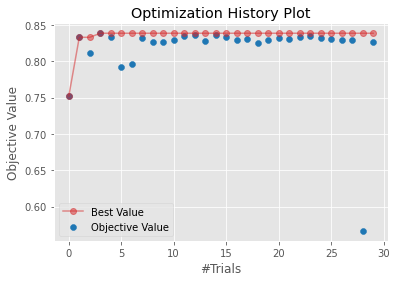

In [7]:
optuna.visualization.matplotlib.plot_optimization_history(lgb_study);

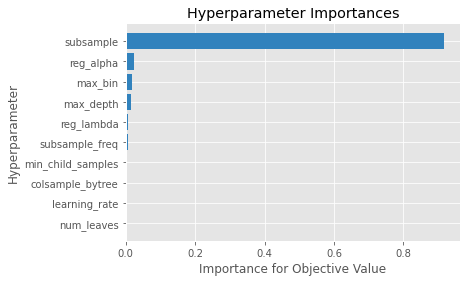

In [8]:
optuna.visualization.matplotlib.plot_param_importances(lgb_study);

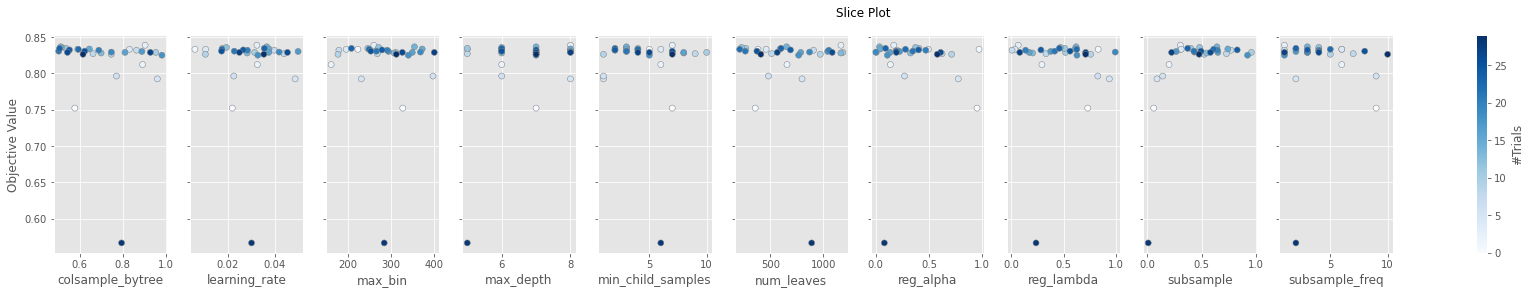

In [9]:
optuna.visualization.matplotlib.plot_slice(lgb_study);

### (2) Training

In [10]:
lucky_seeds = np.random.randint(1, 100, 10) # Lucky seed 늘려가면서 하기

# lgb_pred = np.zeros((test_x.shape[0], 4))

for i, seed in enumerate(lucky_seeds):

    kfold = StratifiedKFold(n_splits=8, random_state = seed, shuffle = True) # CV 늘려가면서 하기
    cv=np.zeros((train_x.shape[0], 4))
    pred_test = np.zeros((test_x.shape[0], 4), dtype=float)

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):
#         print(f"{n+1} Fold Training.....")
        x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
        y_train, y_val = train_y.iloc[train_idx].values.ravel(), train_y.iloc[val_idx].values.ravel()

        lgbmodel = LGBMClassifier(**lgb_best_hyperparams)
        lgbmodel.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=30, verbose=-1)
        
        cv[val_idx,:] = lgbmodel.predict_proba(x_val)
        #print(f'fold{n+1} multi_logloss: {log_loss(y_val, cv[val_idx, :])}') # Fold마다 점수 체크하려면 주석 해제
        pred_test += lgbmodel.predict_proba(test_x) / 8 # CV 바꾸면 이 숫자도 똑같이 바꿔야함
    pred_dict['lgb'+str(seed)] = cv
    pred_test_dict['lgb'+str(seed)] = pred_test
#     print(f'seed {seed}', 'multi_logloss :', log_loss(train_y, cv))
    print(f'seed {seed}', 'accuracy_score :', accuracy_score(train_y, np.argmax(cv, axis=1)))

#         val_cls = np.argmax(val_pred, axis=1)

#         fold_lgb_acc = accuracy_score(y_val, val_cls)
#         lgb_acc.append(fold_lgb_acc)

#         print(f'fold{n+1} score: {fold_lgb_acc}')
#         fold_pred = lgbmodel.predict_proba(test_x) / skf.n_splits
#         lgb_pred += fold_pred

seed 89 accuracy_score : 0.8252676659528908
seed 7 accuracy_score : 0.8265524625267666
seed 71 accuracy_score : 0.8351177730192719
seed 48 accuracy_score : 0.836830835117773
seed 1 accuracy_score : 0.8394004282655246
seed 65 accuracy_score : 0.8342612419700214
seed 76 accuracy_score : 0.8329764453961456
seed 36 accuracy_score : 0.8312633832976445
seed 65 accuracy_score : 0.8342612419700214
seed 59 accuracy_score : 0.8329764453961456


## 3-2. XGB Modeling

In [11]:
def xgb_objective(trial: Trial) -> float:
    params_xgb = {
        "random_state": 42,
        "verbose": None,
        "num_class": 4,
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
        "learning_rate": trial.suggest_uniform("learning_rate", 0.01, 0.05),
        "reg_alpha": trial.suggest_uniform("reg_alpha", 0.0, 0.1), # default=0
        "reg_lambda": trial.suggest_uniform("reg_lambda", 0.0, 0.1), # default=1
        "max_depth": trial.suggest_int("max_depth", 8, 15),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0), # default=0
        "colsample_bylevel": trial.suggest_uniform("colsample_bylevel", 0.5, 1.0),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0), # default=1,
        "min_child_weight": trial.suggest_uniform("min_child_weight", 1, 5), # default=1
        #"max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    
    # CV=5로 튜닝
    
    seed = 42
    kfold = StratifiedKFold(n_splits=5, random_state = seed, shuffle = True) # Cross-validation cv=5
    cv = np.zeros((train_x.shape[0], 4))

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):

        x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
        y_train, y_val = train_y.iloc[train_idx], train_y.iloc[val_idx]
        
        dtrain = xgb.DMatrix(x_train, label=y_train)
        dvalid = xgb.DMatrix(x_val, label=y_val)
        watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
                                                                                            # 진행상황 보고싶을때 None을 100으로
        xgbmodel = xgb.train(params_xgb, dtrain, 100000, watchlist, early_stopping_rounds=30, verbose_eval=None)

        cv[val_idx, :] = xgbmodel.predict(dvalid)
        
#     print('multi_logloss:', log_loss(train_y, cv))
    print('accuracy_score:', accuracy_score(train_y, np.argmax(cv, axis=1)))

    
    return accuracy_score(train_y, np.argmax(cv, axis=1))

In [12]:
sampler = TPESampler(seed=42)
xgb_study = optuna.create_study(study_name="xgb_parameter_opt", direction="maximize", sampler=sampler)
xgb_study.optimize(xgb_objective, n_trials=30)

xgb_best_hyperparams = xgb_study.best_trial.params
xgb_base_hyperparams = {'objective':'multi:softprob', "num_class": 4, "eval_metric": "mlogloss", "random_state": 91373}
xgb_best_hyperparams.update(xgb_base_hyperparams)
print("The best hyperparameters are:\n", xgb_best_hyperparams)

[I 2022-03-16 00:22:06,652] A new study created in memory with name: xgb_parameter_opt
[I 2022-03-16 00:22:35,816] Trial 0 finished with value: 0.8171306209850107 and parameters: {'learning_rate': 0.0249816047538945, 'reg_alpha': 0.09507143064099162, 'reg_lambda': 0.0731993941811405, 'max_depth': 12, 'colsample_bytree': 0.5780093202212182, 'colsample_bylevel': 0.5779972601681014, 'subsample': 0.5290418060840998, 'min_child_weight': 4.46470458309974}. Best is trial 0 with value: 0.8171306209850107.


accuracy_score: 0.8171306209850107


[I 2022-03-16 00:23:05,332] Trial 1 finished with value: 0.8278372591006424 and parameters: {'learning_rate': 0.034044600469728355, 'reg_alpha': 0.07080725777960455, 'reg_lambda': 0.0020584494295802446, 'max_depth': 15, 'colsample_bytree': 0.9162213204002109, 'colsample_bylevel': 0.6061695553391381, 'subsample': 0.5909124836035503, 'min_child_weight': 1.7336180394137353}. Best is trial 1 with value: 0.8278372591006424.


accuracy_score: 0.8278372591006424


[I 2022-03-16 00:23:49,186] Trial 2 finished with value: 0.828693790149893 and parameters: {'learning_rate': 0.02216968971838151, 'reg_alpha': 0.052475643163223784, 'reg_lambda': 0.04319450186421158, 'max_depth': 10, 'colsample_bytree': 0.8059264473611898, 'colsample_bylevel': 0.569746930326021, 'subsample': 0.6460723242676091, 'min_child_weight': 2.465447373174767}. Best is trial 2 with value: 0.828693790149893.


accuracy_score: 0.828693790149893


[I 2022-03-16 00:24:27,900] Trial 3 finished with value: 0.8209850107066381 and parameters: {'learning_rate': 0.02824279936868144, 'reg_alpha': 0.07851759613930137, 'reg_lambda': 0.019967378215835975, 'max_depth': 12, 'colsample_bytree': 0.7962072844310213, 'colsample_bylevel': 0.5232252063599989, 'subsample': 0.8037724259507192, 'min_child_weight': 1.6820964947491661}. Best is trial 2 with value: 0.828693790149893.


accuracy_score: 0.8209850107066381


[I 2022-03-16 00:25:40,867] Trial 4 finished with value: 0.8222698072805139 and parameters: {'learning_rate': 0.01260206371941118, 'reg_alpha': 0.09488855372533334, 'reg_lambda': 0.09656320330745594, 'max_depth': 14, 'colsample_bytree': 0.6523068845866853, 'colsample_bylevel': 0.5488360570031919, 'subsample': 0.8421165132560784, 'min_child_weight': 2.760609974958405}. Best is trial 2 with value: 0.828693790149893.


accuracy_score: 0.8222698072805139


[I 2022-03-16 00:26:42,819] Trial 5 finished with value: 0.8226980728051392 and parameters: {'learning_rate': 0.014881529393791153, 'reg_alpha': 0.04951769101112702, 'reg_lambda': 0.0034388521115218396, 'max_depth': 15, 'colsample_bytree': 0.6293899908000085, 'colsample_bylevel': 0.831261142176991, 'subsample': 0.6558555380447055, 'min_child_weight': 3.0802720847112433}. Best is trial 2 with value: 0.828693790149893.


accuracy_score: 0.8226980728051392


[I 2022-03-16 00:27:26,600] Trial 6 finished with value: 0.8218415417558886 and parameters: {'learning_rate': 0.03186841117373119, 'reg_alpha': 0.018485445552552705, 'reg_lambda': 0.09695846277645587, 'max_depth': 14, 'colsample_bytree': 0.9697494707820946, 'colsample_bylevel': 0.9474136752138245, 'subsample': 0.7989499894055425, 'min_child_weight': 4.687496940092467}. Best is trial 2 with value: 0.828693790149893.


accuracy_score: 0.8218415417558886


[I 2022-03-16 00:28:47,930] Trial 7 finished with value: 0.8141327623126339 and parameters: {'learning_rate': 0.013539700082076781, 'reg_alpha': 0.019598286241914523, 'reg_lambda': 0.004522728891053806, 'max_depth': 10, 'colsample_bytree': 0.6943386448447411, 'colsample_bylevel': 0.6356745158869479, 'subsample': 0.9143687545759647, 'min_child_weight': 2.427013306774357}. Best is trial 2 with value: 0.828693790149893.


accuracy_score: 0.8141327623126339


[I 2022-03-16 00:29:42,680] Trial 8 finished with value: 0.8179871520342612 and parameters: {'learning_rate': 0.02123738038749523, 'reg_alpha': 0.05426960831582485, 'reg_lambda': 0.014092422497476265, 'max_depth': 14, 'colsample_bytree': 0.5372753218398854, 'colsample_bylevel': 0.9934434683002586, 'subsample': 0.8861223846483287, 'min_child_weight': 1.7948627261366896}. Best is trial 2 with value: 0.828693790149893.


accuracy_score: 0.8179871520342612


[I 2022-03-16 00:31:23,382] Trial 9 finished with value: 0.8205567451820128 and parameters: {'learning_rate': 0.010220884684944096, 'reg_alpha': 0.08154614284548342, 'reg_lambda': 0.07068573438476171, 'max_depth': 13, 'colsample_bytree': 0.8856351733429728, 'colsample_bylevel': 0.5370223258670452, 'subsample': 0.6792328642721364, 'min_child_weight': 1.4634762381005189}. Best is trial 2 with value: 0.828693790149893.


accuracy_score: 0.8205567451820128


[I 2022-03-16 00:31:49,838] Trial 10 finished with value: 0.8162740899357601 and parameters: {'learning_rate': 0.04464162634503302, 'reg_alpha': 0.000599718295581704, 'reg_lambda': 0.036872877272109736, 'max_depth': 8, 'colsample_bytree': 0.7846562513261506, 'colsample_bylevel': 0.721539898400351, 'subsample': 0.9798853729727101, 'min_child_weight': 3.6674331003303133}. Best is trial 2 with value: 0.828693790149893.


accuracy_score: 0.8162740899357601


[I 2022-03-16 00:32:12,309] Trial 11 finished with value: 0.8214132762312634 and parameters: {'learning_rate': 0.03978643597802943, 'reg_alpha': 0.055171510081131844, 'reg_lambda': 0.04396874939054679, 'max_depth': 10, 'colsample_bytree': 0.8991358530198216, 'colsample_bylevel': 0.6734956986149505, 'subsample': 0.5354833046372884, 'min_child_weight': 2.171292549502534}. Best is trial 2 with value: 0.828693790149893.


accuracy_score: 0.8214132762312634


[I 2022-03-16 00:32:43,828] Trial 12 finished with value: 0.8265524625267666 and parameters: {'learning_rate': 0.034287370961329035, 'reg_alpha': 0.06801960268501406, 'reg_lambda': 0.029807446028409547, 'max_depth': 9, 'colsample_bytree': 0.8626577352692656, 'colsample_bylevel': 0.620403968750455, 'subsample': 0.6311424598618447, 'min_child_weight': 1.1803763763927035}. Best is trial 2 with value: 0.828693790149893.


accuracy_score: 0.8265524625267666


[I 2022-03-16 00:33:08,956] Trial 13 finished with value: 0.828693790149893 and parameters: {'learning_rate': 0.03804650381575039, 'reg_alpha': 0.0412864065978848, 'reg_lambda': 0.06328866217626596, 'max_depth': 11, 'colsample_bytree': 0.9912255787291955, 'colsample_bylevel': 0.7574852070104716, 'subsample': 0.6025122777220048, 'min_child_weight': 3.3528505586779076}. Best is trial 2 with value: 0.828693790149893.


accuracy_score: 0.828693790149893


[I 2022-03-16 00:34:02,267] Trial 14 finished with value: 0.8244111349036403 and parameters: {'learning_rate': 0.020272441818708478, 'reg_alpha': 0.035316552875821194, 'reg_lambda': 0.06333229554077137, 'max_depth': 11, 'colsample_bytree': 0.9903296632584235, 'colsample_bylevel': 0.8058956479559334, 'subsample': 0.731057379200564, 'min_child_weight': 3.577589650679239}. Best is trial 2 with value: 0.828693790149893.


accuracy_score: 0.8244111349036403


[I 2022-03-16 00:34:24,801] Trial 15 finished with value: 0.8274089935760172 and parameters: {'learning_rate': 0.049925731993111025, 'reg_alpha': 0.03769578122438531, 'reg_lambda': 0.05587985830433146, 'max_depth': 10, 'colsample_bytree': 0.730445357055035, 'colsample_bylevel': 0.8013123222722462, 'subsample': 0.7144330076129229, 'min_child_weight': 3.472369286150053}. Best is trial 2 with value: 0.828693790149893.


accuracy_score: 0.8274089935760172


[I 2022-03-16 00:34:48,353] Trial 16 finished with value: 0.8248394004282655 and parameters: {'learning_rate': 0.04059991921709892, 'reg_alpha': 0.03843269747478527, 'reg_lambda': 0.08220850291417799, 'max_depth': 11, 'colsample_bytree': 0.8276660915094955, 'colsample_bylevel': 0.7265560221042261, 'subsample': 0.5999464358613122, 'min_child_weight': 4.311149037830164}. Best is trial 2 with value: 0.828693790149893.


accuracy_score: 0.8248394004282655


[I 2022-03-16 00:35:24,637] Trial 17 finished with value: 0.8325481798715203 and parameters: {'learning_rate': 0.02696576568322101, 'reg_alpha': 0.020718556927312427, 'reg_lambda': 0.05265790823556293, 'max_depth': 8, 'colsample_bytree': 0.9479531437001762, 'colsample_bylevel': 0.8827490365313595, 'subsample': 0.5065896071904619, 'min_child_weight': 2.9263513487507047}. Best is trial 17 with value: 0.8325481798715203.


accuracy_score: 0.8325481798715203


[I 2022-03-16 00:36:13,372] Trial 18 finished with value: 0.8265524625267666 and parameters: {'learning_rate': 0.01967887819908959, 'reg_alpha': 0.01833051416549058, 'reg_lambda': 0.04864760823862933, 'max_depth': 8, 'colsample_bytree': 0.9354536970072491, 'colsample_bylevel': 0.8932338999425735, 'subsample': 0.5181524066160592, 'min_child_weight': 2.628627737335703}. Best is trial 17 with value: 0.8325481798715203.


accuracy_score: 0.8265524625267666


[I 2022-03-16 00:36:43,528] Trial 19 finished with value: 0.8282655246252677 and parameters: {'learning_rate': 0.027053866643763767, 'reg_alpha': 0.006696638913377566, 'reg_lambda': 0.031940346978070175, 'max_depth': 9, 'colsample_bytree': 0.7417449973053153, 'colsample_bylevel': 0.873069154903134, 'subsample': 0.5019619990437266, 'min_child_weight': 3.9656812770231222}. Best is trial 17 with value: 0.8325481798715203.


accuracy_score: 0.8282655246252677


[I 2022-03-16 00:37:19,970] Trial 20 finished with value: 0.823982869379015 and parameters: {'learning_rate': 0.02533231181133444, 'reg_alpha': 0.027340199043500026, 'reg_lambda': 0.04290279013500598, 'max_depth': 9, 'colsample_bytree': 0.8380549877235325, 'colsample_bylevel': 0.9097268644186695, 'subsample': 0.5711364746991106, 'min_child_weight': 2.09483483292925}. Best is trial 17 with value: 0.8325481798715203.


accuracy_score: 0.823982869379015


[I 2022-03-16 00:37:48,379] Trial 21 finished with value: 0.823982869379015 and parameters: {'learning_rate': 0.03625286704358606, 'reg_alpha': 0.046210342261310496, 'reg_lambda': 0.05692494196761037, 'max_depth': 11, 'colsample_bytree': 0.9981126922026226, 'colsample_bylevel': 0.760566782686188, 'subsample': 0.6353112173152756, 'min_child_weight': 3.110697475012391}. Best is trial 17 with value: 0.8325481798715203.


accuracy_score: 0.823982869379015


[I 2022-03-16 00:38:18,491] Trial 22 finished with value: 0.823982869379015 and parameters: {'learning_rate': 0.029942163606577872, 'reg_alpha': 0.06275885618640871, 'reg_lambda': 0.06392869998302092, 'max_depth': 8, 'colsample_bytree': 0.9105213667974823, 'colsample_bylevel': 0.6993771108098551, 'subsample': 0.5694500677059607, 'min_child_weight': 3.130260671674774}. Best is trial 17 with value: 0.8325481798715203.


accuracy_score: 0.823982869379015


[I 2022-03-16 00:39:00,094] Trial 23 finished with value: 0.8235546038543897 and parameters: {'learning_rate': 0.022381940899123202, 'reg_alpha': 0.02781862258211034, 'reg_lambda': 0.05390704646462428, 'max_depth': 10, 'colsample_bytree': 0.9444007612093025, 'colsample_bylevel': 0.7713774785778301, 'subsample': 0.6848959193488647, 'min_child_weight': 2.718015882883414}. Best is trial 17 with value: 0.8325481798715203.


accuracy_score: 0.8235546038543897


[I 2022-03-16 00:39:53,468] Trial 24 finished with value: 0.823982869379015 and parameters: {'learning_rate': 0.016621450421344344, 'reg_alpha': 0.04406881020199176, 'reg_lambda': 0.08072377880940622, 'max_depth': 9, 'colsample_bytree': 0.9550674869950544, 'colsample_bylevel': 0.6753541372677886, 'subsample': 0.6056690160632353, 'min_child_weight': 3.313797724188312}. Best is trial 17 with value: 0.8325481798715203.


accuracy_score: 0.823982869379015


[I 2022-03-16 00:40:17,451] Trial 25 finished with value: 0.8201284796573876 and parameters: {'learning_rate': 0.039005138781277315, 'reg_alpha': 0.027609472122853307, 'reg_lambda': 0.04035537488360305, 'max_depth': 11, 'colsample_bytree': 0.8532741065379997, 'colsample_bylevel': 0.8532705233244292, 'subsample': 0.5663843167155399, 'min_child_weight': 3.9890122898235756}. Best is trial 17 with value: 0.8325481798715203.


accuracy_score: 0.8201284796573876


[I 2022-03-16 00:40:44,850] Trial 26 finished with value: 0.8244111349036403 and parameters: {'learning_rate': 0.04341320697235173, 'reg_alpha': 0.012818117555813427, 'reg_lambda': 0.022991258025403274, 'max_depth': 12, 'colsample_bytree': 0.7823455662898585, 'colsample_bylevel': 0.9314641905426776, 'subsample': 0.763524848266604, 'min_child_weight': 2.760604083555183}. Best is trial 17 with value: 0.8325481798715203.


accuracy_score: 0.8244111349036403


[I 2022-03-16 00:41:24,931] Trial 27 finished with value: 0.823982869379015 and parameters: {'learning_rate': 0.031401523964600705, 'reg_alpha': 0.031847722380604813, 'reg_lambda': 0.0647305663182357, 'max_depth': 13, 'colsample_bytree': 0.9993570227458746, 'colsample_bylevel': 0.9853942050903831, 'subsample': 0.6897752687935018, 'min_child_weight': 2.3056652104370023}. Best is trial 17 with value: 0.8325481798715203.


accuracy_score: 0.823982869379015


[I 2022-03-16 00:42:02,158] Trial 28 finished with value: 0.8304068522483941 and parameters: {'learning_rate': 0.02431640226770731, 'reg_alpha': 0.06086982207877601, 'reg_lambda': 0.05021998709832601, 'max_depth': 10, 'colsample_bytree': 0.8788106679394715, 'colsample_bylevel': 0.7787588257864038, 'subsample': 0.5513836015917736, 'min_child_weight': 3.876938994227391}. Best is trial 17 with value: 0.8325481798715203.


accuracy_score: 0.8304068522483941


[I 2022-03-16 00:42:34,823] Trial 29 finished with value: 0.8222698072805139 and parameters: {'learning_rate': 0.024310417436136773, 'reg_alpha': 0.06001586094589922, 'reg_lambda': 0.04616951234658579, 'max_depth': 9, 'colsample_bytree': 0.8144091270249295, 'colsample_bylevel': 0.5777684561526654, 'subsample': 0.5390070301751463, 'min_child_weight': 4.847801718201129}. Best is trial 17 with value: 0.8325481798715203.


accuracy_score: 0.8222698072805139
The best hyperparameters are:
 {'learning_rate': 0.02696576568322101, 'reg_alpha': 0.020718556927312427, 'reg_lambda': 0.05265790823556293, 'max_depth': 8, 'colsample_bytree': 0.9479531437001762, 'colsample_bylevel': 0.8827490365313595, 'subsample': 0.5065896071904619, 'min_child_weight': 2.9263513487507047, 'objective': 'multi:softprob', 'num_class': 4, 'eval_metric': 'mlogloss', 'random_state': 91373}


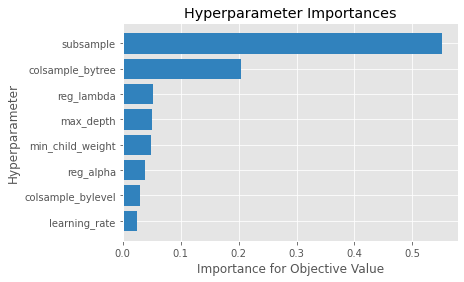

In [13]:
optuna.visualization.matplotlib.plot_param_importances(xgb_study);

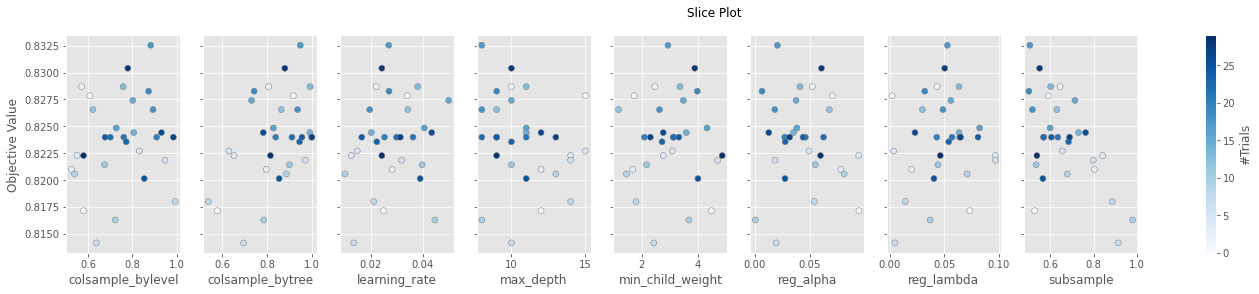

In [14]:
optuna.visualization.matplotlib.plot_slice(xgb_study);

In [15]:
lucky_seeds = np.random.randint(1, 100, 10)
xgtest = xgb.DMatrix(test_x)
for i, seed in enumerate(lucky_seeds):

    kfold = StratifiedKFold(n_splits=8, random_state = seed, shuffle = True) # CV 늘려가면서 하기
    cv=np.zeros((train_x.shape[0], 4))
    pred_test = np.zeros((test_x.shape[0], 4), dtype=float)

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):
#         print(f"{n+1} Fold Training.....")
        x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
        y_train, y_val = train_y.iloc[train_idx].values.ravel(), train_y.iloc[val_idx].values.ravel()
        
        dtrain = xgb.DMatrix(x_train, label=y_train)
        dvalid = xgb.DMatrix(x_val, label=y_val)
        watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
        
                                                                                            # 진행상황 보고싶을때 None을 100으로
        xgbmodel = xgb.train(xgb_best_hyperparams, dtrain, 100000, watchlist, early_stopping_rounds=30, verbose_eval=None)

        cv[val_idx, :] = xgbmodel.predict(dvalid)
        #print(f'fold{n+1} multi_logloss: {log_loss(y_val, cv[val_idx, :])}') # Fold마다 점수 체크하려면 주석 해제
        pred_test += xgbmodel.predict(xgtest) / 8 # CV 바꾸면 이 숫자도 똑같이 바꿔야함
        
    pred_dict['xgb'+str(seed)] = cv
    pred_test_dict['xgb'+str(seed)] = pred_test
#     print(seed, 'multi_logloss :', log_loss(train_y, cv))
    print(f'seed {seed}', 'accuracy_score :', accuracy_score(train_y, np.argmax(cv, axis=1)))

75 multi_logloss : 0.459732171914295
seed 75 accuracy_score : 0.8295503211991435
54 multi_logloss : 0.4505883223590256
seed 54 accuracy_score : 0.8334047109207708
45 multi_logloss : 0.46494620303707496
seed 45 accuracy_score : 0.823982869379015
30 multi_logloss : 0.4528261587939934
seed 30 accuracy_score : 0.828693790149893
27 multi_logloss : 0.44929248800114674
seed 27 accuracy_score : 0.8325481798715203
69 multi_logloss : 0.45714346433519154
seed 69 accuracy_score : 0.8325481798715203
75 multi_logloss : 0.459732171914295
seed 75 accuracy_score : 0.8295503211991435
58 multi_logloss : 0.4505895540218301
seed 58 accuracy_score : 0.8295503211991435
85 multi_logloss : 0.4610809336852864
seed 85 accuracy_score : 0.8201284796573876
16 multi_logloss : 0.4584430018795129
seed 16 accuracy_score : 0.832119914346895


## 3-3. CNN Modeling

### (1) HP Tuning

In [16]:
train_x = train.iloc[:, 1:-1]
test_x = test.iloc[:, 1:]

train_x = np.array(train_x).reshape(-1, 8, 4, 1)
test_x = np.array(test_x).reshape(-1, 8, 4, 1)

ohe = OneHotEncoder(sparse = False)
train_y = ohe.fit_transform(train[['target']])

In [17]:
def create_model(num_layer, mid_units, num_filters):
    
    model = Sequential()
    model.add(Conv2D(filters=num_filters[0], kernel_size=(2, 2),
                 activation="elu",
                 input_shape=(8, 4, 1)))
    model.add(BatchNormalization())
    #model.add(Dropout(dropout_rate[0]))
    for i in range(1,num_layer):
        model.add(Conv2D(filters=num_filters[i], kernel_size=(2, 2), padding="same", activation="elu"))
        model.add(BatchNormalization())
        #model.add(Dropout(dropout_rate[i+1]))
            
    model.add(GlobalAveragePooling2D())
    model.add(Dense(mid_units, activation='relu'))
    #model.add(Dropout(dropout_rate[-1]))
    model.add(Dense(4, activation='softmax'))
    
    return model

In [18]:
def cnn_objective(trial: Trial) -> float:
    
    #clear_session
    keras.backend.clear_session()
    
    #number of the convolution layer
    num_layer = trial.suggest_int("num_layer", 2, 3)
    
    #number of the unit
    mid_units = int(trial.suggest_discrete_uniform("mid_units", 30, 150, 10))
    
    #number of the each convolution layer filter
    num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]

    #Dropout
    #dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    #dropout_rate = [int(trial.suggest_uniform("dropout_rate"+str(ii), 0.0, 0.5)) for ii in range(num_layer+1)]
    
        
    seed = 42
    kfold = StratifiedKFold(n_splits=5, random_state = seed, shuffle = True) # Cross-validation cv=5
    es = EarlyStopping(monitor="val_acc", patience=5, mode="max", verbose=0)
    cv = np.zeros((train_x.shape[0], 4))

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train.target)):

        x_train, y_train = train_x[train_idx], train_y[train_idx]
        x_val, y_val = train_x[val_idx], train_y[val_idx]
        
        mc = ModelCheckpoint(f"model_{n+1}.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=0)
        
        model = create_model(num_layer, mid_units, num_filters)
        
        # Adam optimizer learning rate
        optimizer = Adam(learning_rate=trial.suggest_uniform("learning_rate", 0.0005, 0.005))
        model.compile(optimizer=optimizer,
                      loss="categorical_crossentropy",
                      metrics=["acc"])
        model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, 
                  callbacks=[es,mc], verbose=None)
        
        best = load_model(f"model_{n+1}.h5")
        
        cv[val_idx, :] = best.predict(x_val)
        
#     print('multi_logloss:', log_loss(train_y, cv))
    print('accuracy_score:', accuracy_score(np.argmax(train_y, axis=1), np.argmax(cv, axis=1)))

    
    return accuracy_score(np.argmax(train_y, axis=1), np.argmax(cv, axis=1))

In [19]:
sampler = TPESampler(seed=42)
cnn_study = optuna.create_study(study_name="cnn_parameter_opt", direction="maximize", sampler=sampler)
cnn_study.optimize(cnn_objective, n_trials=30)

[I 2022-03-16 00:52:41,494] A new study created in memory with name: cnn_parameter_opt
[I 2022-03-16 00:53:38,207] Trial 0 finished with value: 0.8680942184154176 and parameters: {'num_layer': 2, 'mid_units': 150.0, 'num_filter_0': 192.0, 'num_filter_1': 160.0, 'learning_rate': 0.0012020838819909643}. Best is trial 0 with value: 0.8680942184154176.


multi_logloss: 0.37885724229643436
accuracy_score: 0.8680942184154176


[I 2022-03-16 00:54:24,476] Trial 1 finished with value: 0.8655246252676659 and parameters: {'num_layer': 2, 'mid_units': 30.0, 'num_filter_0': 224.0, 'num_filter_1': 160.0, 'learning_rate': 0.003686326600082205}. Best is trial 0 with value: 0.8680942184154176.


multi_logloss: 0.38679851216536854
accuracy_score: 0.8655246252676659


[I 2022-03-16 00:55:17,176] Trial 2 finished with value: 0.8758029978586723 and parameters: {'num_layer': 2, 'mid_units': 150.0, 'num_filter_0': 224.0, 'num_filter_1': 64.0, 'learning_rate': 0.001318212352431953}. Best is trial 2 with value: 0.8758029978586723.


multi_logloss: 0.36873859421257266
accuracy_score: 0.8758029978586723


[I 2022-03-16 00:56:15,884] Trial 3 finished with value: 0.8805139186295503 and parameters: {'num_layer': 2, 'mid_units': 60.0, 'num_filter_0': 144.0, 'num_filter_1': 112.0, 'learning_rate': 0.0018105311308911887}. Best is trial 3 with value: 0.8805139186295503.


multi_logloss: 0.3601332232874037
accuracy_score: 0.8805139186295503


[I 2022-03-16 00:56:58,281] Trial 4 finished with value: 0.867237687366167 and parameters: {'num_layer': 3, 'mid_units': 40.0, 'num_filter_0': 80.0, 'num_filter_1': 96.0, 'num_filter_2': 128.0, 'learning_rate': 0.004033291826268562}. Best is trial 3 with value: 0.8805139186295503.


multi_logloss: 0.41176301754943995
accuracy_score: 0.867237687366167


[I 2022-03-16 00:57:40,592] Trial 5 finished with value: 0.8706638115631692 and parameters: {'num_layer': 2, 'mid_units': 90.0, 'num_filter_0': 160.0, 'num_filter_1': 16.0, 'learning_rate': 0.003233951833556473}. Best is trial 3 with value: 0.8805139186295503.


multi_logloss: 0.37159663631399314
accuracy_score: 0.8706638115631692


[I 2022-03-16 00:58:44,230] Trial 6 finished with value: 0.8629550321199143 and parameters: {'num_layer': 2, 'mid_units': 30.0, 'num_filter_0': 256.0, 'num_filter_1': 256.0, 'learning_rate': 0.004137788066524076}. Best is trial 3 with value: 0.8805139186295503.


multi_logloss: 0.40017892349145967
accuracy_score: 0.8629550321199143


[I 2022-03-16 00:59:39,175] Trial 7 finished with value: 0.8689507494646681 and parameters: {'num_layer': 2, 'mid_units': 40.0, 'num_filter_0': 176.0, 'num_filter_1': 128.0, 'learning_rate': 0.0010491720568015048}. Best is trial 3 with value: 0.8805139186295503.


multi_logloss: 0.3840712772103178
accuracy_score: 0.8689507494646681


[I 2022-03-16 01:00:25,939] Trial 8 finished with value: 0.8689507494646681 and parameters: {'num_layer': 2, 'mid_units': 30.0, 'num_filter_0': 240.0, 'num_filter_1': 80.0, 'learning_rate': 0.0034813502795929194}. Best is trial 3 with value: 0.8805139186295503.


multi_logloss: 0.38949620932134094
accuracy_score: 0.8689507494646681


[I 2022-03-16 01:01:09,597] Trial 9 finished with value: 0.8638115631691649 and parameters: {'num_layer': 2, 'mid_units': 90.0, 'num_filter_0': 144.0, 'num_filter_1': 48.0, 'learning_rate': 0.004863130824940514}. Best is trial 3 with value: 0.8805139186295503.


multi_logloss: 0.38540255121079453
accuracy_score: 0.8638115631691649


[I 2022-03-16 01:02:05,545] Trial 10 finished with value: 0.8633832976445396 and parameters: {'num_layer': 3, 'mid_units': 70.0, 'num_filter_0': 16.0, 'num_filter_1': 224.0, 'num_filter_2': 256.0, 'learning_rate': 0.0022113183211331486}. Best is trial 3 with value: 0.8805139186295503.


multi_logloss: 0.40199091593318603
accuracy_score: 0.8633832976445396


[I 2022-03-16 01:02:43,926] Trial 11 finished with value: 0.867237687366167 and parameters: {'num_layer': 3, 'mid_units': 150.0, 'num_filter_0': 96.0, 'num_filter_1': 96.0, 'num_filter_2': 16.0, 'learning_rate': 0.002102410505007472}. Best is trial 3 with value: 0.8805139186295503.


multi_logloss: 0.3880672154074741
accuracy_score: 0.867237687366167


[I 2022-03-16 01:03:35,433] Trial 12 finished with value: 0.8680942184154176 and parameters: {'num_layer': 2, 'mid_units': 120.0, 'num_filter_0': 96.0, 'num_filter_1': 32.0, 'learning_rate': 0.0005501547434808009}. Best is trial 3 with value: 0.8805139186295503.


multi_logloss: 0.3833367769405913
accuracy_score: 0.8680942184154176


[I 2022-03-16 01:04:22,772] Trial 13 finished with value: 0.8702355460385439 and parameters: {'num_layer': 2, 'mid_units': 60.0, 'num_filter_0': 208.0, 'num_filter_1': 64.0, 'learning_rate': 0.0019251830475718803}. Best is trial 3 with value: 0.8805139186295503.


multi_logloss: 0.37603635313948436
accuracy_score: 0.8702355460385439


[I 2022-03-16 01:05:15,079] Trial 14 finished with value: 0.8732334047109208 and parameters: {'num_layer': 3, 'mid_units': 120.0, 'num_filter_0': 32.0, 'num_filter_1': 128.0, 'num_filter_2': 256.0, 'learning_rate': 0.0015221255524289538}. Best is trial 3 with value: 0.8805139186295503.


multi_logloss: 0.35478331456222656
accuracy_score: 0.8732334047109208


[I 2022-03-16 01:05:57,369] Trial 15 finished with value: 0.8693790149892934 and parameters: {'num_layer': 2, 'mid_units': 110.0, 'num_filter_0': 128.0, 'num_filter_1': 160.0, 'learning_rate': 0.0027360349838550803}. Best is trial 3 with value: 0.8805139186295503.


multi_logloss: 0.36759835664752527
accuracy_score: 0.8693790149892934


[I 2022-03-16 01:06:48,676] Trial 16 finished with value: 0.859100642398287 and parameters: {'num_layer': 2, 'mid_units': 70.0, 'num_filter_0': 128.0, 'num_filter_1': 192.0, 'learning_rate': 0.0005970278729622882}. Best is trial 3 with value: 0.8805139186295503.


multi_logloss: 0.4036086556475993
accuracy_score: 0.859100642398287


[I 2022-03-16 01:07:36,160] Trial 17 finished with value: 0.8715203426124197 and parameters: {'num_layer': 3, 'mid_units': 60.0, 'num_filter_0': 64.0, 'num_filter_1': 112.0, 'num_filter_2': 32.0, 'learning_rate': 0.002549914172654393}. Best is trial 3 with value: 0.8805139186295503.


multi_logloss: 0.3875886217322507
accuracy_score: 0.8715203426124197


[I 2022-03-16 01:08:20,296] Trial 18 finished with value: 0.8732334047109208 and parameters: {'num_layer': 2, 'mid_units': 130.0, 'num_filter_0': 208.0, 'num_filter_1': 64.0, 'learning_rate': 0.0016198203516354245}. Best is trial 3 with value: 0.8805139186295503.


multi_logloss: 0.37473941385295867
accuracy_score: 0.8732334047109208


[I 2022-03-16 01:09:12,346] Trial 19 finished with value: 0.8689507494646681 and parameters: {'num_layer': 2, 'mid_units': 100.0, 'num_filter_0': 256.0, 'num_filter_1': 16.0, 'learning_rate': 0.0009780901897896873}. Best is trial 3 with value: 0.8805139186295503.


multi_logloss: 0.37620727221847
accuracy_score: 0.8689507494646681


[I 2022-03-16 01:10:02,667] Trial 20 finished with value: 0.8723768736616703 and parameters: {'num_layer': 3, 'mid_units': 70.0, 'num_filter_0': 192.0, 'num_filter_1': 80.0, 'num_filter_2': 160.0, 'learning_rate': 0.0015984801473727123}. Best is trial 3 with value: 0.8805139186295503.


multi_logloss: 0.37504119603158226
accuracy_score: 0.8723768736616703


[I 2022-03-16 01:10:54,499] Trial 21 finished with value: 0.8766595289079229 and parameters: {'num_layer': 2, 'mid_units': 140.0, 'num_filter_0': 224.0, 'num_filter_1': 48.0, 'learning_rate': 0.0019261514668153959}. Best is trial 3 with value: 0.8805139186295503.


multi_logloss: 0.36993467892080206
accuracy_score: 0.8766595289079229


[I 2022-03-16 01:11:40,408] Trial 22 finished with value: 0.8736616702355461 and parameters: {'num_layer': 2, 'mid_units': 140.0, 'num_filter_0': 224.0, 'num_filter_1': 48.0, 'learning_rate': 0.0023434286788078327}. Best is trial 3 with value: 0.8805139186295503.


multi_logloss: 0.3647119816650689
accuracy_score: 0.8736616702355461


[I 2022-03-16 01:12:28,571] Trial 23 finished with value: 0.8728051391862955 and parameters: {'num_layer': 2, 'mid_units': 140.0, 'num_filter_0': 160.0, 'num_filter_1': 48.0, 'learning_rate': 0.003042742782032193}. Best is trial 3 with value: 0.8805139186295503.


multi_logloss: 0.36345356268923534
accuracy_score: 0.8728051391862955


[I 2022-03-16 01:13:27,369] Trial 24 finished with value: 0.8728051391862955 and parameters: {'num_layer': 2, 'mid_units': 130.0, 'num_filter_0': 224.0, 'num_filter_1': 96.0, 'learning_rate': 0.001902578450651423}. Best is trial 3 with value: 0.8805139186295503.


multi_logloss: 0.3689857410286995
accuracy_score: 0.8728051391862955


[I 2022-03-16 01:14:15,850] Trial 25 finished with value: 0.8736616702355461 and parameters: {'num_layer': 2, 'mid_units': 150.0, 'num_filter_0': 176.0, 'num_filter_1': 64.0, 'learning_rate': 0.0014416426050839432}. Best is trial 3 with value: 0.8805139186295503.


multi_logloss: 0.3656081423486726
accuracy_score: 0.8736616702355461


[I 2022-03-16 01:15:35,755] Trial 26 finished with value: 0.8732334047109208 and parameters: {'num_layer': 2, 'mid_units': 110.0, 'num_filter_0': 240.0, 'num_filter_1': 112.0, 'learning_rate': 0.0008677122037054781}. Best is trial 3 with value: 0.8805139186295503.


multi_logloss: 0.3807137948157937
accuracy_score: 0.8732334047109208


[I 2022-03-16 01:16:12,133] Trial 27 finished with value: 0.8732334047109208 and parameters: {'num_layer': 2, 'mid_units': 140.0, 'num_filter_0': 112.0, 'num_filter_1': 32.0, 'learning_rate': 0.0018540978647379677}. Best is trial 3 with value: 0.8805139186295503.


multi_logloss: 0.37888907223353874
accuracy_score: 0.8732334047109208


[I 2022-03-16 01:17:10,970] Trial 28 finished with value: 0.8685224839400428 and parameters: {'num_layer': 2, 'mid_units': 80.0, 'num_filter_0': 192.0, 'num_filter_1': 144.0, 'learning_rate': 0.00259797739686038}. Best is trial 3 with value: 0.8805139186295503.


multi_logloss: 0.38534193551967977
accuracy_score: 0.8685224839400428


[I 2022-03-16 01:18:22,071] Trial 29 finished with value: 0.8680942184154176 and parameters: {'num_layer': 2, 'mid_units': 150.0, 'num_filter_0': 192.0, 'num_filter_1': 192.0, 'learning_rate': 0.0022454866510934995}. Best is trial 3 with value: 0.8805139186295503.


multi_logloss: 0.3953591451073436
accuracy_score: 0.8680942184154176


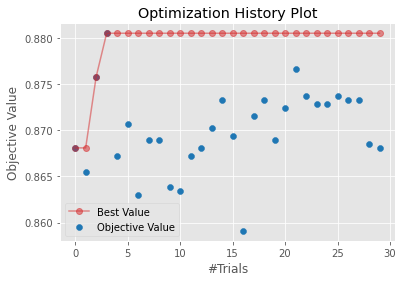

In [20]:
optuna.visualization.matplotlib.plot_optimization_history(cnn_study);

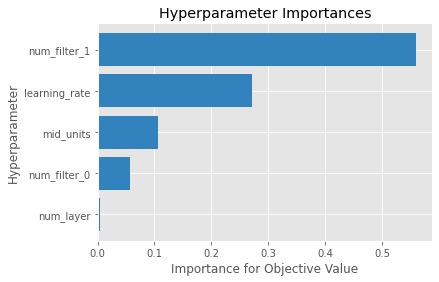

In [21]:
optuna.visualization.matplotlib.plot_param_importances(cnn_study);

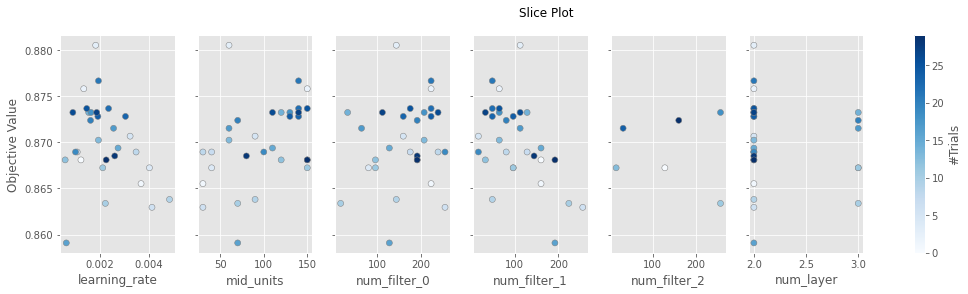

In [22]:
optuna.visualization.matplotlib.plot_slice(cnn_study);

In [23]:
lucky_seeds = np.random.randint(1, 100, 10) # Lucky seed 늘려가면서 하기

for i, seed in enumerate(lucky_seeds):

    kfold = StratifiedKFold(n_splits=8, random_state = seed, shuffle = True) # CV 늘려가면서 하기
    cv=np.zeros((train_x.shape[0], 4))
    pred_test = np.zeros((test_x.shape[0], 4), dtype=float)
    es = EarlyStopping(monitor="val_acc", patience=5, mode="max", verbose=0)
    
    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train.target)):
#         print(f"{n+1} Fold Training.....")
        x_train, y_train = train_x[train_idx], train_y[train_idx]
        x_val, y_val = train_x[val_idx], train_y[val_idx]

        cnn = create_model(cnn_study.best_params['num_layer'], cnn_study.best_params['mid_units'], 
                  [cnn_study.best_params[f'num_filter_{i}'] for i in range(cnn_study.best_params['num_layer'])])

        # ModelCheckpoint Fold마다 갱신
        mc = ModelCheckpoint(f"model_{i+1}.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=0)

        # 모델 Complie
        optimizer = Adam(learning_rate=cnn_study.best_params['learning_rate'])
        cnn.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"])
        cnn.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, 
                callbacks=[es,mc], verbose=0)

        # 최고 성능 기록 모델
        best = load_model(f"model_{i+1}.h5")
        
        cv[val_idx,:] = best.predict(x_val)
        #print(f'fold{n+1} multi_logloss: {log_loss(y_val, cv[val_idx, :])}') # Fold마다 점수 체크하려면 주석 해제
        pred_test += best.predict(test_x) / 8 # CV 바꾸면 이 숫자도 똑같이 바꿔야함
    pred_dict['cnn'+str(seed)] = cv
    pred_test_dict['cnn'+str(seed)] = pred_test
#     print(f'seed {seed}', 'multi_logloss :', log_loss(train_y, cv))
    print(f'seed {seed}', 'accuracy_score :', accuracy_score(np.argmax(train_y, axis=1), np.argmax(cv, axis=1)))

seed 88 accuracy_score : 0.8758029978586723
seed 65 accuracy_score : 0.8706638115631692
seed 52 accuracy_score : 0.8749464668094219
seed 47 accuracy_score : 0.8770877944325481
seed 34 accuracy_score : 0.8762312633832976
seed 88 accuracy_score : 0.8770877944325481
seed 88 accuracy_score : 0.8758029978586723
seed 59 accuracy_score : 0.880085653104925
seed 70 accuracy_score : 0.8736616702355461
seed 39 accuracy_score : 0.8745182012847966


## 4. Stacking (XGB)

In [24]:
def sort_dict(model, pred_dict, pred_test_dict):
    pred_dict_local = {}
    for key, value in pred_dict.items():
        if model in key:
            pred_dict_local[key]=value

    pred_test_dict_local = {}
    for key, value in pred_test_dict.items():
        if model in key:
            pred_test_dict_local[key]=value

    pred_dict_new_local = dict(sorted(pred_dict_local.items(), key=lambda x:log_loss(train_y, list(x[1])), reverse=False)[:3])
    pred_test_dict_new_local = {}
    for key, value in pred_dict_new_local.items():
        pred_test_dict_new_local[key]=pred_test_dict_local[key]
        
    return pred_dict_new_local, pred_test_dict_new_local

In [25]:
pred_dict_lgb, pred_test_dict_lgb = sort_dict('lgb', pred_dict, pred_test_dict)
pred_dict_xgb, pred_test_dict_xgb = sort_dict('xgb', pred_dict, pred_test_dict)
# pred_dict_rf, pred_test_dict_rf = sort_dict('rf', pred_dict, pred_test_dict)
pred_dict_cnn, pred_test_dict_cnn = sort_dict('cnn', pred_dict, pred_test_dict)

In [26]:
def save_dict(model, pred_dict, pred_test_dict):
    with open('./pkl/pred_dict_'+model+'.pickle', 'wb') as fw:
        pickle.dump(pred_dict, fw)

    with open('./pkl/pred_test_dict_'+model+'.pickle', 'wb') as fw:
        pickle.dump(pred_test_dict, fw)

In [27]:
def create_dir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
        print("Created Directory :", dir)
    else:
        print("Directory already existed :", dir)
create_dir("pkl")

Directory already existed : pkl


In [28]:
save_dict('lgb', pred_dict_lgb, pred_test_dict_lgb)
save_dict('xgb', pred_dict_xgb, pred_test_dict_xgb)
#save_dict('rf', pred_dict_rf, pred_test_dict_rf)
save_dict('cnn', pred_dict_cnn, pred_test_dict_cnn)

In [29]:
def load_dict(model):
    with open('./pkl/pred_dict_'+model+'.pickle', 'rb') as fw:
        pred_dict_new_local = pickle.load(fw)

    with open('./pkl/pred_test_dict_'+model+'.pickle', 'rb') as fw:
        pred_test_dict_new_local = pickle.load(fw)
        
    return pred_dict_new_local, pred_test_dict_new_local

In [30]:
pred_dict_lgb, pred_test_dict_lgb = load_dict('lgb')
pred_dict_xgb, pred_test_dict_xgb = load_dict('xgb')
# pred_dict_rf, pred_test_dict_rf = load_dict('rf')
pred_dict_cnn, pred_test_dict_cnn = load_dict('cnn')

In [31]:
pred_dict_total = {**pred_dict_lgb, **pred_dict_xgb, **pred_dict_cnn}
pred_test_dict_total = {**pred_test_dict_lgb, **pred_test_dict_xgb, **pred_test_dict_cnn}

In [32]:
train_y = train.iloc[:, -1:]

In [33]:
def stack_objective(trial: Trial) -> float:
    params_xgb = {
        "random_state": 91373,
        "verbose": None,
        "num_class": 4,
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
        #"tree_method": "gpu_hist",
        "learning_rate": trial.suggest_uniform("learning_rate", 0.0005, 0.01),
        "reg_alpha": trial.suggest_uniform("reg_alpha", 0.1, 1.0),
        "reg_lambda": trial.suggest_uniform("reg_lambda", 0.1, 1.0),
        "max_depth": trial.suggest_int("max_depth", 2, 8),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.6),
        "colsample_bylevel": trial.suggest_uniform("colsample_bylevel", 0.3, 1.0),
        "subsample": trial.suggest_uniform("subsample", 0.3, 1.0),
        "gamma": trial.suggest_uniform("gamma", 0.3, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    
    # CV=5로 튜닝
    
    seed = 42
    kfold = StratifiedKFold(n_splits=5, random_state = seed, shuffle = True) # Cross-validation cv=5
    cv = np.zeros((train_x.shape[0], 4))

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):

        x_train, x_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train, y_val = train_y.iloc[train_idx], train_y.iloc[val_idx]
        
        dtrain = xgb.DMatrix(x_train, label=y_train)
        dvalid = xgb.DMatrix(x_val, label=y_val)
        watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
                                                                                            # 진행상황 보고싶을때 None을 100으로
        stack_xgbmodel = xgb.train(params_xgb, dtrain, 100000, watchlist, early_stopping_rounds=30, verbose_eval=None)

        cv[val_idx, :] = stack_xgbmodel.predict(dvalid)
        #print(f'fold{n+1} multi_logloss: {log_loss(y_val, cv[val_idx, :])}') # Fold마다 점수 체크하려면 주석 해제
#     print('multi_logloss:', log_loss(train_y, cv))
    print('accuracy_score:', accuracy_score(train_y, np.argmax(cv, axis=1)))

    return accuracy_score(train_y, np.argmax(cv, axis=1))

In [34]:
X_train = pd.DataFrame(np.hstack([x for _, x in pred_dict_total.items()]))
X_test = pd.DataFrame(np.hstack([x for _, x in pred_test_dict_total.items()]))

sampler = TPESampler(seed=42)
stack_study = optuna.create_study(study_name="stack_parameter_opt", direction="maximize", sampler=sampler)
stack_study.optimize(stack_objective, n_trials=50)

stack_best_hyperparams = stack_study.best_trial.params
stack_base_hyperparams = {'objective':'multi:softprob', "num_class": 4, "eval_metric": "mlogloss", "random_state": 42}
stack_best_hyperparams.update(stack_base_hyperparams)
print("The best hyperparameters are:\n", stack_best_hyperparams)

[I 2022-03-16 01:34:49,973] A new study created in memory with name: stack_parameter_opt
[I 2022-03-16 01:35:32,308] Trial 0 finished with value: 0.8916488222698072 and parameters: {'learning_rate': 0.004058131129049944, 'reg_alpha': 0.9556428757689246, 'reg_lambda': 0.7587945476302645, 'max_depth': 6, 'colsample_bytree': 0.17800932022121826, 'colsample_bylevel': 0.40919616423534183, 'subsample': 0.3406585285177396, 'gamma': 0.9063233020424546, 'min_child_weight': 7, 'max_bin': 413}. Best is trial 0 with value: 0.8916488222698072.


accuracy_score: 0.8916488222698072


[I 2022-03-16 01:39:28,083] Trial 1 finished with value: 0.892933618843683 and parameters: {'learning_rate': 0.0006955526958101233, 'reg_alpha': 0.9729188669457949, 'reg_lambda': 0.8491983767203796, 'max_depth': 3, 'colsample_bytree': 0.19091248360355031, 'colsample_bylevel': 0.4283831568974037, 'subsample': 0.5129695700716763, 'gamma': 0.6673295021425665, 'min_child_weight': 5, 'max_bin': 287}. Best is trial 1 with value: 0.892933618843683.


accuracy_score: 0.892933618843683


[I 2022-03-16 01:39:48,237] Trial 2 finished with value: 0.8907922912205567 and parameters: {'learning_rate': 0.006312602499862605, 'reg_alpha': 0.22554447458683766, 'reg_lambda': 0.3629301836816964, 'max_depth': 4, 'colsample_bytree': 0.32803499210851794, 'colsample_bylevel': 0.8496231729751094, 'subsample': 0.4397716475108518, 'gamma': 0.6599641068895281, 'min_child_weight': 6, 'max_bin': 213}. Best is trial 1 with value: 0.892933618843683.


accuracy_score: 0.8907922912205567


[I 2022-03-16 01:40:15,374] Trial 3 finished with value: 0.8873661670235546 and parameters: {'learning_rate': 0.006271676093063665, 'reg_alpha': 0.2534717113185624, 'reg_lambda': 0.1585464336867516, 'max_depth': 8, 'colsample_bytree': 0.5828160165372797, 'colsample_bylevel': 0.8658781436815228, 'subsample': 0.5132296384213595, 'gamma': 0.3683704798044687, 'min_child_weight': 7, 'max_bin': 332}. Best is trial 1 with value: 0.892933618843683.


accuracy_score: 0.8873661670235546


[I 2022-03-16 01:41:45,040] Trial 4 finished with value: 0.889507494646681 and parameters: {'learning_rate': 0.0016593632310253988, 'reg_alpha': 0.5456592191001431, 'reg_lambda': 0.13094966900369656, 'max_depth': 8, 'colsample_bytree': 0.22938999080000846, 'colsample_bylevel': 0.7637655990477874, 'subsample': 0.5181977532625877, 'gamma': 0.6640476148244676, 'min_child_weight': 6, 'max_bin': 255}. Best is trial 1 with value: 0.892933618843683.


accuracy_score: 0.889507494646681


[I 2022-03-16 01:42:05,222] Trial 5 finished with value: 0.8916488222698072 and parameters: {'learning_rate': 0.009711053963763306, 'reg_alpha': 0.7976195410250031, 'reg_lambda': 0.9455490474077702, 'max_depth': 8, 'colsample_bytree': 0.3989499894055426, 'colsample_bylevel': 0.9453119645161818, 'subsample': 0.36194475143634364, 'gamma': 0.4371880036934016, 'min_child_weight': 1, 'max_bin': 297}. Best is trial 1 with value: 0.892933618843683.


accuracy_score: 0.8916488222698072


[I 2022-03-16 01:42:38,992] Trial 6 finished with value: 0.892933618843683 and parameters: {'learning_rate': 0.004192434252050079, 'reg_alpha': 0.34421412859650635, 'reg_lambda': 0.8458637582367364, 'max_depth': 4, 'colsample_bytree': 0.2404672548436904, 'colsample_bylevel': 0.6798872582107739, 'subsample': 0.3986469574823338, 'gamma': 0.8615378865278278, 'min_child_weight': 1, 'max_bin': 497}. Best is trial 1 with value: 0.892933618843683.


accuracy_score: 0.892933618843683


[I 2022-03-16 01:43:03,282] Trial 7 finished with value: 0.8869379014989294 and parameters: {'learning_rate': 0.007836325308318246, 'reg_alpha': 0.2788441133807552, 'reg_lambda': 0.10496990541124217, 'max_depth': 7, 'colsample_bytree': 0.45342867192380854, 'colsample_bylevel': 0.810305017628691, 'subsample': 0.8398892426801621, 'gamma': 0.35183125621386324, 'min_child_weight': 4, 'max_bin': 234}. Best is trial 1 with value: 0.892933618843683.


accuracy_score: 0.8869379014989294


[I 2022-03-16 01:43:21,573] Trial 8 finished with value: 0.8925053533190578 and parameters: {'learning_rate': 0.008699482545818139, 'reg_alpha': 0.6609683141448022, 'reg_lambda': 0.39780822236738433, 'max_depth': 2, 'colsample_bytree': 0.2554911608578311, 'colsample_bylevel': 0.5276283254187228, 'subsample': 0.8107243248366449, 'gamma': 0.7462902299486491, 'min_child_weight': 9, 'max_bin': 342}. Best is trial 1 with value: 0.892933618843683.


accuracy_score: 0.8925053533190578


[I 2022-03-16 01:45:04,612] Trial 9 finished with value: 0.8916488222698072 and parameters: {'learning_rate': 0.0016361453364138663, 'reg_alpha': 0.7419203085006955, 'reg_lambda': 0.7847065437552077, 'max_depth': 5, 'colsample_bytree': 0.48548358997728047, 'colsample_bylevel': 0.6456569174550735, 'subsample': 0.6659129805673958, 'gamma': 0.5992787128509847, 'min_child_weight': 1, 'max_bin': 232}. Best is trial 1 with value: 0.892933618843683.


accuracy_score: 0.8916488222698072


[I 2022-03-16 01:51:40,308] Trial 10 finished with value: 0.8886509635974305 and parameters: {'learning_rate': 0.0006950181004561794, 'reg_alpha': 0.9394437550391957, 'reg_lambda': 0.6220267779791122, 'max_depth': 2, 'colsample_bytree': 0.10814805429705951, 'colsample_bylevel': 0.3271076399728281, 'subsample': 0.9718395221617941, 'gamma': 0.5277519985798994, 'min_child_weight': 4, 'max_bin': 405}. Best is trial 1 with value: 0.892933618843683.


accuracy_score: 0.8886509635974305


[I 2022-03-16 01:52:22,061] Trial 11 finished with value: 0.8916488222698072 and parameters: {'learning_rate': 0.003585191469905623, 'reg_alpha': 0.4665025629824473, 'reg_lambda': 0.9550678930951746, 'max_depth': 4, 'colsample_bytree': 0.28352253489840873, 'colsample_bylevel': 0.5637150147215133, 'subsample': 0.6085324725238765, 'gamma': 0.9985126798318373, 'min_child_weight': 3, 'max_bin': 485}. Best is trial 1 with value: 0.892933618843683.


accuracy_score: 0.8916488222698072


[I 2022-03-16 01:53:03,206] Trial 12 finished with value: 0.8925053533190578 and parameters: {'learning_rate': 0.003633373095536302, 'reg_alpha': 0.41112437072344, 'reg_lambda': 0.7828446626118897, 'max_depth': 3, 'colsample_bytree': 0.15354222382410093, 'colsample_bylevel': 0.46466293484034865, 'subsample': 0.30356304805484713, 'gamma': 0.7983844615493881, 'min_child_weight': 10, 'max_bin': 485}. Best is trial 1 with value: 0.892933618843683.


accuracy_score: 0.8925053533190578


[I 2022-03-16 01:54:01,431] Trial 13 finished with value: 0.892933618843683 and parameters: {'learning_rate': 0.0023611984341645083, 'reg_alpha': 0.10650392550867441, 'reg_lambda': 0.6249044385696946, 'max_depth': 4, 'colsample_bytree': 0.19876907657652568, 'colsample_bylevel': 0.6504019666002822, 'subsample': 0.4645905326026264, 'gamma': 0.8329514613788555, 'min_child_weight': 3, 'max_bin': 416}. Best is trial 1 with value: 0.892933618843683.


accuracy_score: 0.892933618843683


[I 2022-03-16 01:54:27,914] Trial 14 finished with value: 0.8916488222698072 and parameters: {'learning_rate': 0.005254369269056083, 'reg_alpha': 0.40063407130778605, 'reg_lambda': 0.8675815964448497, 'max_depth': 3, 'colsample_bytree': 0.3261631564388042, 'colsample_bylevel': 0.7048904064817584, 'subsample': 0.6069537852081703, 'gamma': 0.9784888964341025, 'min_child_weight': 2, 'max_bin': 287}. Best is trial 1 with value: 0.892933618843683.


accuracy_score: 0.8916488222698072


[I 2022-03-16 01:56:01,923] Trial 15 finished with value: 0.8899357601713062 and parameters: {'learning_rate': 0.002590213321360513, 'reg_alpha': 0.6233178839215556, 'reg_lambda': 0.9988508300371832, 'max_depth': 5, 'colsample_bytree': 0.10237005982654465, 'colsample_bylevel': 0.3068310070177048, 'subsample': 0.41391001285755524, 'gamma': 0.7381985473785279, 'min_child_weight': 8, 'max_bin': 373}. Best is trial 1 with value: 0.892933618843683.


accuracy_score: 0.8899357601713062


[I 2022-03-16 02:00:26,204] Trial 16 finished with value: 0.8933618843683083 and parameters: {'learning_rate': 0.0005181359630157634, 'reg_alpha': 0.8519356539065581, 'reg_lambda': 0.48250449642324955, 'max_depth': 3, 'colsample_bytree': 0.2906963121250142, 'colsample_bylevel': 0.5846412321322172, 'subsample': 0.6972031781820933, 'gamma': 0.8770433677521827, 'min_child_weight': 5, 'max_bin': 445}. Best is trial 16 with value: 0.8933618843683083.


accuracy_score: 0.8933618843683083


[I 2022-03-16 02:03:04,326] Trial 17 finished with value: 0.892933618843683 and parameters: {'learning_rate': 0.0008448957257051262, 'reg_alpha': 0.8433100602190778, 'reg_lambda': 0.4837119994846846, 'max_depth': 3, 'colsample_bytree': 0.3840671054645703, 'colsample_bylevel': 0.5496927787956498, 'subsample': 0.7179471694523338, 'gamma': 0.5342415334441871, 'min_child_weight': 5, 'max_bin': 445}. Best is trial 16 with value: 0.8933618843683083.


accuracy_score: 0.892933618843683


[I 2022-03-16 02:05:47,672] Trial 18 finished with value: 0.891220556745182 and parameters: {'learning_rate': 0.0007374759141206568, 'reg_alpha': 0.8470339866591675, 'reg_lambda': 0.4372285241532048, 'max_depth': 2, 'colsample_bytree': 0.3952908891858085, 'colsample_bylevel': 0.5655698044799544, 'subsample': 0.7281828923414102, 'gamma': 0.5346608514569231, 'min_child_weight': 5, 'max_bin': 456}. Best is trial 16 with value: 0.8933618843683083.


accuracy_score: 0.891220556745182


[I 2022-03-16 02:07:00,285] Trial 19 finished with value: 0.8890792291220557 and parameters: {'learning_rate': 0.0026177470996702574, 'reg_alpha': 0.9967364989471184, 'reg_lambda': 0.30528598177621785, 'max_depth': 6, 'colsample_bytree': 0.3020843771180813, 'colsample_bylevel': 0.40119589181131216, 'subsample': 0.8543257345382245, 'gamma': 0.9111996999653109, 'min_child_weight': 4, 'max_bin': 301}. Best is trial 16 with value: 0.8933618843683083.


accuracy_score: 0.8890792291220557


[I 2022-03-16 02:08:34,462] Trial 20 finished with value: 0.8916488222698072 and parameters: {'learning_rate': 0.0017975830828485368, 'reg_alpha': 0.7196480793604321, 'reg_lambda': 0.6387388658972715, 'max_depth': 3, 'colsample_bytree': 0.14639362217008323, 'colsample_bylevel': 0.47097673293693826, 'subsample': 0.542771612527047, 'gamma': 0.7722019288238222, 'min_child_weight': 7, 'max_bin': 373}. Best is trial 16 with value: 0.8933618843683083.


accuracy_score: 0.8916488222698072


[I 2022-03-16 02:10:38,442] Trial 21 finished with value: 0.8933618843683083 and parameters: {'learning_rate': 0.0010599490872243008, 'reg_alpha': 0.8613169232717708, 'reg_lambda': 0.49854351555413157, 'max_depth': 3, 'colsample_bytree': 0.3657610886591501, 'colsample_bylevel': 0.5087421194294758, 'subsample': 0.7288676131287146, 'gamma': 0.48343510625628794, 'min_child_weight': 5, 'max_bin': 448}. Best is trial 16 with value: 0.8933618843683083.


accuracy_score: 0.8933618843683083


[I 2022-03-16 02:14:03,258] Trial 22 finished with value: 0.8920770877944325 and parameters: {'learning_rate': 0.0006739658818598598, 'reg_alpha': 0.8947764665036821, 'reg_lambda': 0.5344549137842425, 'max_depth': 3, 'colsample_bytree': 0.3515455607674821, 'colsample_bylevel': 0.4704570081208361, 'subsample': 0.7835256601353304, 'gamma': 0.47265319418513774, 'min_child_weight': 5, 'max_bin': 458}. Best is trial 16 with value: 0.8933618843683083.


accuracy_score: 0.8920770877944325


[I 2022-03-16 02:15:27,475] Trial 23 finished with value: 0.8920770877944325 and parameters: {'learning_rate': 0.0016020846998727827, 'reg_alpha': 0.7753174998700741, 'reg_lambda': 0.25476418670172046, 'max_depth': 2, 'colsample_bytree': 0.45341646435498234, 'colsample_bylevel': 0.3756937332073808, 'subsample': 0.9156801594673274, 'gamma': 0.6805355222761595, 'min_child_weight': 6, 'max_bin': 372}. Best is trial 16 with value: 0.8933618843683083.


accuracy_score: 0.8920770877944325


[I 2022-03-16 02:16:20,683] Trial 24 finished with value: 0.8907922912205567 and parameters: {'learning_rate': 0.0030051656156839667, 'reg_alpha': 0.8910378998630228, 'reg_lambda': 0.5539404058922474, 'max_depth': 5, 'colsample_bytree': 0.27733726852244, 'colsample_bylevel': 0.6025600833215415, 'subsample': 0.6761320275352157, 'gamma': 0.3059437791678427, 'min_child_weight': 3, 'max_bin': 434}. Best is trial 16 with value: 0.8933618843683083.


accuracy_score: 0.8907922912205567


[I 2022-03-16 02:18:13,321] Trial 25 finished with value: 0.891220556745182 and parameters: {'learning_rate': 0.0013369959734418969, 'reg_alpha': 0.6400885702425472, 'reg_lambda': 0.6787571471309283, 'max_depth': 3, 'colsample_bytree': 0.20742750839261132, 'colsample_bylevel': 0.4872751543658077, 'subsample': 0.6166483855152793, 'gamma': 0.5884625193465671, 'min_child_weight': 4, 'max_bin': 269}. Best is trial 16 with value: 0.8933618843683083.


accuracy_score: 0.891220556745182


[I 2022-03-16 02:18:45,470] Trial 26 finished with value: 0.8882226980728052 and parameters: {'learning_rate': 0.0047689989521137, 'reg_alpha': 0.972574607501188, 'reg_lambda': 0.47044672509904917, 'max_depth': 4, 'colsample_bytree': 0.5286505235414793, 'colsample_bylevel': 0.6222335233967933, 'subsample': 0.7421084362072125, 'gamma': 0.426871607272529, 'min_child_weight': 5, 'max_bin': 320}. Best is trial 16 with value: 0.8933618843683083.


accuracy_score: 0.8882226980728052


[I 2022-03-16 02:19:44,940] Trial 27 finished with value: 0.891220556745182 and parameters: {'learning_rate': 0.002387586992021468, 'reg_alpha': 0.15221481868749973, 'reg_lambda': 0.5666739558657996, 'max_depth': 4, 'colsample_bytree': 0.3526305727829125, 'colsample_bylevel': 0.7384448865046608, 'subsample': 0.5692189543538462, 'gamma': 0.8347810433903404, 'min_child_weight': 3, 'max_bin': 402}. Best is trial 16 with value: 0.8933618843683083.


accuracy_score: 0.891220556745182


[I 2022-03-16 02:21:01,546] Trial 28 finished with value: 0.892933618843683 and parameters: {'learning_rate': 0.002303874702742061, 'reg_alpha': 0.547168721018295, 'reg_lambda': 0.69888855574576, 'max_depth': 5, 'colsample_bytree': 0.26299914487493814, 'colsample_bylevel': 0.6033136619070872, 'subsample': 0.6865156530608592, 'gamma': 0.9342369639686776, 'min_child_weight': 2, 'max_bin': 428}. Best is trial 16 with value: 0.8933618843683083.


accuracy_score: 0.892933618843683


[I 2022-03-16 02:22:00,399] Trial 29 finished with value: 0.8907922912205567 and parameters: {'learning_rate': 0.003287598181736474, 'reg_alpha': 0.5804223219558469, 'reg_lambda': 0.7198790966445354, 'max_depth': 6, 'colsample_bytree': 0.43389971119681037, 'colsample_bylevel': 0.5082506637859285, 'subsample': 0.7726232924985633, 'gamma': 0.9052886456828984, 'min_child_weight': 2, 'max_bin': 469}. Best is trial 16 with value: 0.8933618843683083.


accuracy_score: 0.8907922912205567


[I 2022-03-16 02:27:39,369] Trial 30 finished with value: 0.8903640256959314 and parameters: {'learning_rate': 0.00054792491414422, 'reg_alpha': 0.9313157234281885, 'reg_lambda': 0.33066201988138344, 'max_depth': 2, 'colsample_bytree': 0.18511717345445064, 'colsample_bylevel': 0.42019203024582086, 'subsample': 0.8792731816575602, 'gamma': 0.608950716471875, 'min_child_weight': 8, 'max_bin': 389}. Best is trial 16 with value: 0.8933618843683083.


accuracy_score: 0.8903640256959314


[I 2022-03-16 02:29:41,143] Trial 31 finished with value: 0.8899357601713062 and parameters: {'learning_rate': 0.0012401259600887272, 'reg_alpha': 0.531283458335283, 'reg_lambda': 0.8583379171963695, 'max_depth': 5, 'colsample_bytree': 0.3085005794506311, 'colsample_bylevel': 0.5851060787916947, 'subsample': 0.6992935179554645, 'gamma': 0.9327732368679141, 'min_child_weight': 6, 'max_bin': 431}. Best is trial 16 with value: 0.8933618843683083.


accuracy_score: 0.8899357601713062


[I 2022-03-16 02:31:21,727] Trial 32 finished with value: 0.8916488222698072 and parameters: {'learning_rate': 0.0021090827616341993, 'reg_alpha': 0.8492958162825791, 'reg_lambda': 0.7253026398141259, 'max_depth': 7, 'colsample_bytree': 0.2661217880086796, 'colsample_bylevel': 0.44171813954824296, 'subsample': 0.6436836612231501, 'gamma': 0.721728786710413, 'min_child_weight': 2, 'max_bin': 430}. Best is trial 16 with value: 0.8933618843683083.


accuracy_score: 0.8916488222698072


[I 2022-03-16 02:33:51,825] Trial 33 finished with value: 0.8916488222698072 and parameters: {'learning_rate': 0.0011614698138248114, 'reg_alpha': 0.6986570440655445, 'reg_lambda': 0.5213626893513736, 'max_depth': 3, 'colsample_bytree': 0.2234839763313076, 'colsample_bylevel': 0.3656949978445375, 'subsample': 0.7535850292911974, 'gamma': 0.9498905028683338, 'min_child_weight': 7, 'max_bin': 470}. Best is trial 16 with value: 0.8933618843683083.


accuracy_score: 0.8916488222698072


[I 2022-03-16 02:34:18,826] Trial 34 finished with value: 0.8937901498929336 and parameters: {'learning_rate': 0.006226697157175243, 'reg_alpha': 0.7921990359330664, 'reg_lambda': 0.40491910262877556, 'max_depth': 3, 'colsample_bytree': 0.15780678718338947, 'colsample_bylevel': 0.49870853172176366, 'subsample': 0.46658588943748547, 'gamma': 0.8912280021868279, 'min_child_weight': 5, 'max_bin': 201}. Best is trial 34 with value: 0.8937901498929336.


accuracy_score: 0.8937901498929336


[I 2022-03-16 02:34:47,337] Trial 35 finished with value: 0.8920770877944325 and parameters: {'learning_rate': 0.006467286539574561, 'reg_alpha': 0.796366787716847, 'reg_lambda': 0.40900815994608686, 'max_depth': 4, 'colsample_bytree': 0.14016210371621438, 'colsample_bylevel': 0.5226511744258197, 'subsample': 0.571137321903185, 'gamma': 0.8832892344081285, 'min_child_weight': 6, 'max_bin': 419}. Best is trial 34 with value: 0.8937901498929336.


accuracy_score: 0.8920770877944325


[I 2022-03-16 02:35:06,128] Trial 36 finished with value: 0.8937901498929336 and parameters: {'learning_rate': 0.006805517810765645, 'reg_alpha': 0.8415747084500677, 'reg_lambda': 0.473706687736278, 'max_depth': 3, 'colsample_bytree': 0.38115741239552714, 'colsample_bylevel': 0.5488549789941318, 'subsample': 0.4755708350516802, 'gamma': 0.5272167480261826, 'min_child_weight': 5, 'max_bin': 442}. Best is trial 34 with value: 0.8937901498929336.


accuracy_score: 0.8937901498929336


[I 2022-03-16 02:35:24,806] Trial 37 finished with value: 0.892933618843683 and parameters: {'learning_rate': 0.00698181239647017, 'reg_alpha': 0.8702955967759052, 'reg_lambda': 0.2598363130494557, 'max_depth': 2, 'colsample_bytree': 0.35391493713876415, 'colsample_bylevel': 0.5031715061766608, 'subsample': 0.474485871207388, 'gamma': 0.48328179130692217, 'min_child_weight': 5, 'max_bin': 356}. Best is trial 34 with value: 0.8937901498929336.


accuracy_score: 0.892933618843683


[I 2022-03-16 02:35:47,384] Trial 38 finished with value: 0.8937901498929336 and parameters: {'learning_rate': 0.005522675437101073, 'reg_alpha': 0.7819355963738721, 'reg_lambda': 0.3607553392543279, 'max_depth': 3, 'colsample_bytree': 0.4212822471794586, 'colsample_bylevel': 0.9603656604898907, 'subsample': 0.3466649828658481, 'gamma': 0.38967842504485084, 'min_child_weight': 4, 'max_bin': 449}. Best is trial 34 with value: 0.8937901498929336.


accuracy_score: 0.8937901498929336


[I 2022-03-16 02:36:09,632] Trial 39 finished with value: 0.8907922912205567 and parameters: {'learning_rate': 0.005615894635660278, 'reg_alpha': 0.7666447130167418, 'reg_lambda': 0.2103256577292549, 'max_depth': 4, 'colsample_bytree': 0.42194561775153905, 'colsample_bylevel': 0.8296003788525175, 'subsample': 0.3517677443179259, 'gamma': 0.38051123239009876, 'min_child_weight': 4, 'max_bin': 202}. Best is trial 34 with value: 0.8937901498929336.


accuracy_score: 0.8907922912205567


[I 2022-03-16 02:36:26,050] Trial 40 finished with value: 0.892933618843683 and parameters: {'learning_rate': 0.007481967021249475, 'reg_alpha': 0.6871398496276102, 'reg_lambda': 0.36413346692817133, 'max_depth': 2, 'colsample_bytree': 0.513287989449828, 'colsample_bylevel': 0.9482190325956054, 'subsample': 0.3778737209026075, 'gamma': 0.3131776144348093, 'min_child_weight': 6, 'max_bin': 390}. Best is trial 34 with value: 0.8937901498929336.


accuracy_score: 0.892933618843683


[I 2022-03-16 02:36:45,756] Trial 41 finished with value: 0.892933618843683 and parameters: {'learning_rate': 0.00600445124833215, 'reg_alpha': 0.8119185004511721, 'reg_lambda': 0.4738915653262535, 'max_depth': 3, 'colsample_bytree': 0.3806839373046258, 'colsample_bylevel': 0.9106905489521964, 'subsample': 0.3182200271318467, 'gamma': 0.4144006669454724, 'min_child_weight': 4, 'max_bin': 460}. Best is trial 34 with value: 0.8937901498929336.


accuracy_score: 0.892933618843683


[I 2022-03-16 02:37:06,289] Trial 42 finished with value: 0.8916488222698072 and parameters: {'learning_rate': 0.006897048550752563, 'reg_alpha': 0.9016005180985164, 'reg_lambda': 0.3800354790578755, 'max_depth': 3, 'colsample_bytree': 0.4131640808798469, 'colsample_bylevel': 0.990638868841113, 'subsample': 0.43009410651629715, 'gamma': 0.4827401507447387, 'min_child_weight': 5, 'max_bin': 445}. Best is trial 34 with value: 0.8937901498929336.


accuracy_score: 0.8916488222698072


[I 2022-03-16 02:37:22,933] Trial 43 finished with value: 0.889507494646681 and parameters: {'learning_rate': 0.008159641421580132, 'reg_alpha': 0.747545882088164, 'reg_lambda': 0.42414777238814366, 'max_depth': 4, 'colsample_bytree': 0.4852763592516492, 'colsample_bylevel': 0.6712097148853733, 'subsample': 0.4907277264642265, 'gamma': 0.39668624063535696, 'min_child_weight': 6, 'max_bin': 484}. Best is trial 34 with value: 0.8937901498929336.


accuracy_score: 0.889507494646681


[I 2022-03-16 02:37:48,213] Trial 44 finished with value: 0.8916488222698072 and parameters: {'learning_rate': 0.004625646775548041, 'reg_alpha': 0.8195173900073858, 'reg_lambda': 0.314084466228151, 'max_depth': 3, 'colsample_bytree': 0.5955908392334932, 'colsample_bylevel': 0.549585801997175, 'subsample': 0.45012617037240044, 'gamma': 0.5553915221609967, 'min_child_weight': 4, 'max_bin': 495}. Best is trial 34 with value: 0.8937901498929336.


accuracy_score: 0.8916488222698072


[I 2022-03-16 02:38:07,052] Trial 45 finished with value: 0.8916488222698072 and parameters: {'learning_rate': 0.005821419936709549, 'reg_alpha': 0.9235023791505916, 'reg_lambda': 0.4459235944371592, 'max_depth': 2, 'colsample_bytree': 0.30609501576011794, 'colsample_bylevel': 0.7462651378512005, 'subsample': 0.3811987349321243, 'gamma': 0.44261086040449754, 'min_child_weight': 5, 'max_bin': 445}. Best is trial 34 with value: 0.8937901498929336.


accuracy_score: 0.8916488222698072


[I 2022-03-16 02:38:24,331] Trial 46 finished with value: 0.8946466809421841 and parameters: {'learning_rate': 0.00664305662335764, 'reg_alpha': 0.7304781100107156, 'reg_lambda': 0.5878203774111166, 'max_depth': 3, 'colsample_bytree': 0.371704751659161, 'colsample_bylevel': 0.7788700941218609, 'subsample': 0.33221890264706666, 'gamma': 0.348932642301999, 'min_child_weight': 7, 'max_bin': 229}. Best is trial 46 with value: 0.8946466809421841.


accuracy_score: 0.8946466809421841


[I 2022-03-16 02:38:42,713] Trial 47 finished with value: 0.8925053533190578 and parameters: {'learning_rate': 0.006602688573963002, 'reg_alpha': 0.73325375186206, 'reg_lambda': 0.5930906310445851, 'max_depth': 4, 'colsample_bytree': 0.37277115829650337, 'colsample_bylevel': 0.8759409304091597, 'subsample': 0.3260766584848033, 'gamma': 0.34650611446878943, 'min_child_weight': 8, 'max_bin': 226}. Best is trial 46 with value: 0.8946466809421841.


accuracy_score: 0.8925053533190578


[I 2022-03-16 02:38:55,575] Trial 48 finished with value: 0.8916488222698072 and parameters: {'learning_rate': 0.00973597136792203, 'reg_alpha': 0.6714511127072302, 'reg_lambda': 0.5097697936978549, 'max_depth': 3, 'colsample_bytree': 0.4529118232827701, 'colsample_bylevel': 0.7703343496402073, 'subsample': 0.4022298448171203, 'gamma': 0.33766919667810286, 'min_child_weight': 7, 'max_bin': 258}. Best is trial 46 with value: 0.8946466809421841.


accuracy_score: 0.8916488222698072


[I 2022-03-16 02:39:14,734] Trial 49 finished with value: 0.8907922912205567 and parameters: {'learning_rate': 0.005273471855342854, 'reg_alpha': 0.6025251700317659, 'reg_lambda': 0.3488555580450773, 'max_depth': 2, 'colsample_bytree': 0.3349271793126997, 'colsample_bylevel': 0.9086654541201313, 'subsample': 0.3505073791291073, 'gamma': 0.4587574890508297, 'min_child_weight': 9, 'max_bin': 215}. Best is trial 46 with value: 0.8946466809421841.


accuracy_score: 0.8907922912205567
The best hyperparameters are:
 {'learning_rate': 0.00664305662335764, 'reg_alpha': 0.7304781100107156, 'reg_lambda': 0.5878203774111166, 'max_depth': 3, 'colsample_bytree': 0.371704751659161, 'colsample_bylevel': 0.7788700941218609, 'subsample': 0.33221890264706666, 'gamma': 0.348932642301999, 'min_child_weight': 7, 'max_bin': 229, 'objective': 'multi:softprob', 'num_class': 4, 'eval_metric': 'mlogloss', 'random_state': 42}


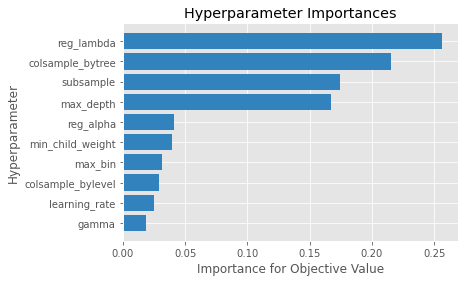

In [35]:
optuna.visualization.matplotlib.plot_param_importances(stack_study);

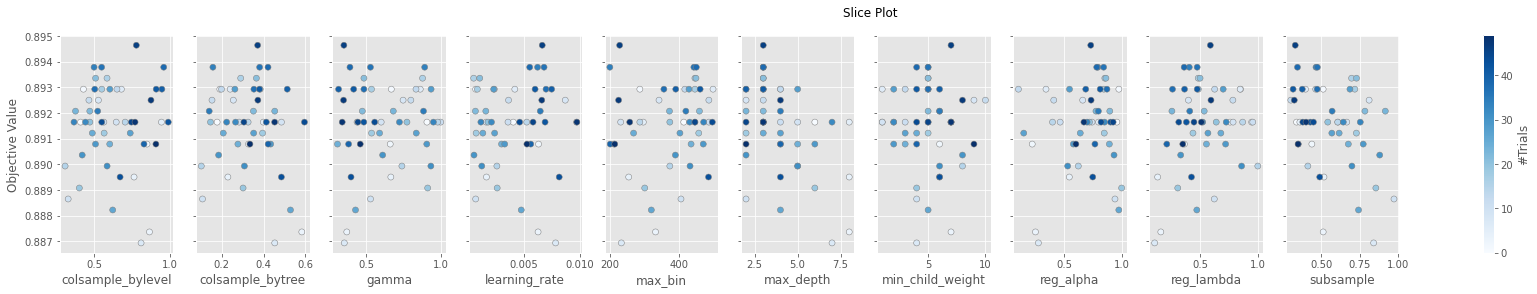

In [36]:
optuna.visualization.matplotlib.plot_slice(stack_study);

In [37]:
pred = np.zeros((X_train.shape[0], 4), dtype=float)
pred_test = np.zeros((X_test.shape[0], 4), dtype=float)
kfold = StratifiedKFold(n_splits=8, random_state = 42, shuffle = True)

for n, (train_idx, val_idx) in enumerate(kfold.split(X_train, train_y)):
    x_train, x_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train, y_val = train_y.iloc[train_idx], train_y.iloc[val_idx]

    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_val, label=y_val)
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
                                                                                        # 진행상황 보고싶을때 None을 100으로
    stack_xgbmodel = xgb.train(stack_best_hyperparams, dtrain, 100000, watchlist, early_stopping_rounds=30, verbose_eval=None)
    
    pred[val_idx] = stack_xgbmodel.predict(dvalid)
    pred_test += stack_xgbmodel.predict(xgb.DMatrix(X_test)) / 8

In [38]:
print(f'CV Log Loss: {log_loss(train_y, pred):.6f}')
print(f'CV Accuracy Score: {accuracy_score(train_y, np.argmax(pred, axis=1)):.6f}')

CV Log Loss: 0.332483
CV Accuracy Score: 0.891221


In [39]:
stack_train = pred.copy()
stack_test = pred_test.copy()

## 5. Blending

In [104]:
pred_final = (sum(pred_dict_lgb.values())/3 * 0 +
              sum(pred_dict_xgb.values())/3 * 0 +
               sum(pred_dict_cnn.values())/3 * 0 +
                               stack_train * 1)
accuracy_score(train_y, np.argmax(pred_final, axis=1))

0.891220556745182

In [93]:
pred_final = (sum(pred_dict_lgb.values())/3 * 1 +
              sum(pred_dict_xgb.values())/3 * 1 +
               sum(pred_dict_cnn.values())/3 * 1 +
                               stack_train * 20)
accuracy_score(train_y, np.argmax(pred_final, axis=1))

0.8933618843683083

In [101]:
pred_final = (sum(pred_dict_lgb.values())/3 * 1 +
              sum(pred_dict_xgb.values())/3 * 1 +
               sum(pred_dict_cnn.values())/3 * 5 +
                               stack_train * 5)
accuracy_score(train_y, np.argmax(pred_final, axis=1))

0.891220556745182

In [105]:
pred_test_final = (sum(pred_test_dict_lgb.values())/3 * 0 +
                   sum(pred_test_dict_xgb.values())/3 * 0 +
                    sum(pred_test_dict_cnn.values())/3 * 0 +
                                          stack_test * 1)

## 6. Submission

In [106]:
def create_dir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
        print("Created Directory :", dir)
    else:
        print("Directory already existed :", dir)
create_dir("submission")

Directory already existed : submission


In [107]:
submission['target'] = np.argmax(pred_test_final, axis=1)
submission.to_csv('submission/20220316-3.csv', index = False)
submission.target.value_counts()

1    2451
2    2431
0    2255
3    2206
Name: target, dtype: int64